# Home Credit Default Risk

## Business Problem

* Home Credit is a international non-bank financial institution.
* The problem is of risk modelling.
* Given the data of a client we have to predict if he/she is able to repay loan or  will have difficulty in paying back.

## Data Provided by Home Credit

## Reference
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

## Why we need Data Science in this Problem?

* The decision of whether a person can repay a loan or not, can be decided if we just get the previous data of the client. 
* But using existing techniques there are defaulters.
* If we use statistical and machine learning methods to make these predictions It will be a double confirmation before lending some one which is better than single.
* There can be some clients which have some data missing then it becomes difficult so we can impute them using predictive models by training on available data. 
* Also we can find some common trends observed by people acting as defaulter , which is very difficult to observe mannually.

## Metric AUC-ROC score

* The data has target = 0 for people who can repay the loan and target = 1 for people who cannot repay loan.
* The data is imbalanced.
* Home credit will face losses if model predicton is wrong that is <br>
     * If the model has predicted client will repay loan but actually he has defaulted.(Scenario 1) 
     * If the model has predicted client will default but he can actually pay loan back deserving candidate not getting loan,bank loss in return intrest.(Scenario 2)
* But the loss will be much more in (Scenario 1) ie If the model has predicted client will repay loan but actually he has defaulted .
* So we want to know of all the points actually positive how many of them are predicted positive.
* Accuracy cannot be used for imbalanced.
* Precison is not important since it will tell of all the points that are predicted to be positive how may of them are actually positive.
* Recall is important since it will tell of all the points that are actually positive how may of them are predicted positive. So recall is important to identify the (Scenario 1). If Recall is high means defaluters are correctly predicted as defaulters
* F1 score is geometric mean of precision and recall and precision and is hight if recall and precision are high.Since we have no use of precision here, F1 score or micro F1 score or macro F1 score is not important.
* In AUC-ROC score we have True Positive Rate and False Postive Rate,<br>
     * True Positive Rate is same as Recall so (Scenario 1) gets coverd.
     *  False Postive Rate is out of all the points that are actulally negative how many are predicted as positive. (Scenario 2).
* Hence AUC-ROC score is an important metric since it cover both scenarios where Home Credit can suffer loss.
        

In [6]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
sns.set_style("whitegrid");
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle as pkl
import tqdm as tqdm
from random import choices
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
# from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import Ridge

# application_train.csv and application_test.csv

### application_{train|test}.csv

* This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
* Static data for all applications. One row represents one loan in our data sample.

In [12]:
app_train=pd.read_csv('application_train.csv')
app_test=pd.read_csv('application_test.csv')

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
app_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

<h3>Check the if the data is balanced or imbalanced ?</h3>

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Text(0.5, 1.0, 'Target count')

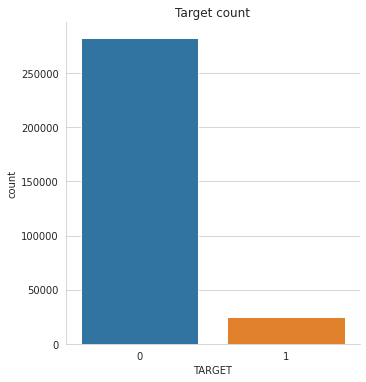

In [ ]:
ax=sns.catplot(x="TARGET", kind="count", data=app_train)
plt.title('Target count')

<h4>Analysis:</h4>

* The people who are able to repay loan back is greater than 250000 and people who have difficulty in paying loan back are less thant 50000.

* So it is clearly visible that the number of people who paid loan on time is much greater then the number of people had difficulty in paying loan back.

<h4>Conclusion:</h4>

* So our data set is imbalanced and we have to give proper weights while training.

In [15]:
def missing_values(df):
    '''
    Get the missing values percentage in decending order
    '''
    mis_val=df.isnull().sum()
    mis_val_percent =100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [ ]:
missing_values_data=missing_values(app_train)

Dataframe has 122 columns.
There are 67 columns that have missing values.


In [ ]:
missing_values_data.head(20)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [ ]:
#The values that don't have any missing values hence these will be very useful to create new features
print("The columns that do not have missing values: ")
not_missing_columns=list(set(app_train.columns)-set(missing_values_data.index))
not_missing_columns

The columns that do not have missing values: 


['FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_10',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_CONT_MOBILE',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_12',
 'NAME_HOUSING_TYPE',
 'DAYS_REGISTRATION',
 'FLAG_DOCUMENT_13',
 'NAME_CONTRACT_TYPE',
 'CNT_CHILDREN',
 'FLAG_EMP_PHONE',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_5',
 'WEEKDAY_APPR_PROCESS_START',
 'LIVE_REGION_NOT_WORK_REGION',
 'CODE_GENDER',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_6',
 'FLAG_PHONE',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_EMAIL',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'TARGET',
 'AMT_CREDIT',
 'FLAG_OWN_REALTY',
 'DAYS_EMPLOYED',
 'FLAG_DOCUMENT_7',
 'NAME_EDUCATION_TYPE',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_4',
 'FLAG_WORK_PHONE',
 'FLAG_MOBIL',
 'REGION_RATING_CLIENT',
 'FLAG_DOCUMENT_19',
 'HOUR_APPR_PROCESS_START',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_18',
 'SK_ID_CURR',
 'F

In [ ]:
#column count based on data type
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [ ]:
#column count based on data type for columns that do not have any missing data 
app_train[not_missing_columns].dtypes.value_counts()

int64      41
object     10
float64     4
dtype: int64

In [ ]:
#column count based on data type for columns that do have  missing data 
app_train[missing_values_data.index].dtypes.value_counts()

float64    61
object      6
dtype: int64

<h3>Amount credit (Credit amount of the loan)</h3>

Text(0, 0.5, 'Density')

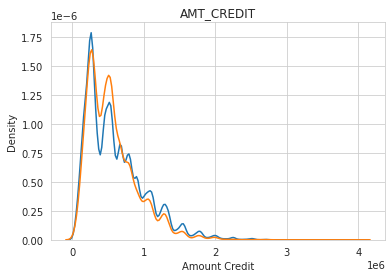

In [ ]:
ax=sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_CREDIT'] , label = 'target == 0')
ax=sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_CREDIT'] , label = 'target == 1')
ax.title.set_text('AMT_CREDIT')
ax.set_xlabel('Amount Credit')
ax.set_ylabel('Density')

<h4>Analysis</h4>

* Amount Credit is the amount requested by the applicant.
* The desity is high for the amount less than 10^6 by for both type of applicants who can pay and have difficulty in paying loan.
* The graph looks right skewed.

<h4>Conclusion</h4>

* It is clear that the data is highly overlapping between the people who are able to pay loan on time and the people who had difficulty in paying loan back.
* So it is not of much use.

<h3>Amount Income Total (Income of the client)</h3>

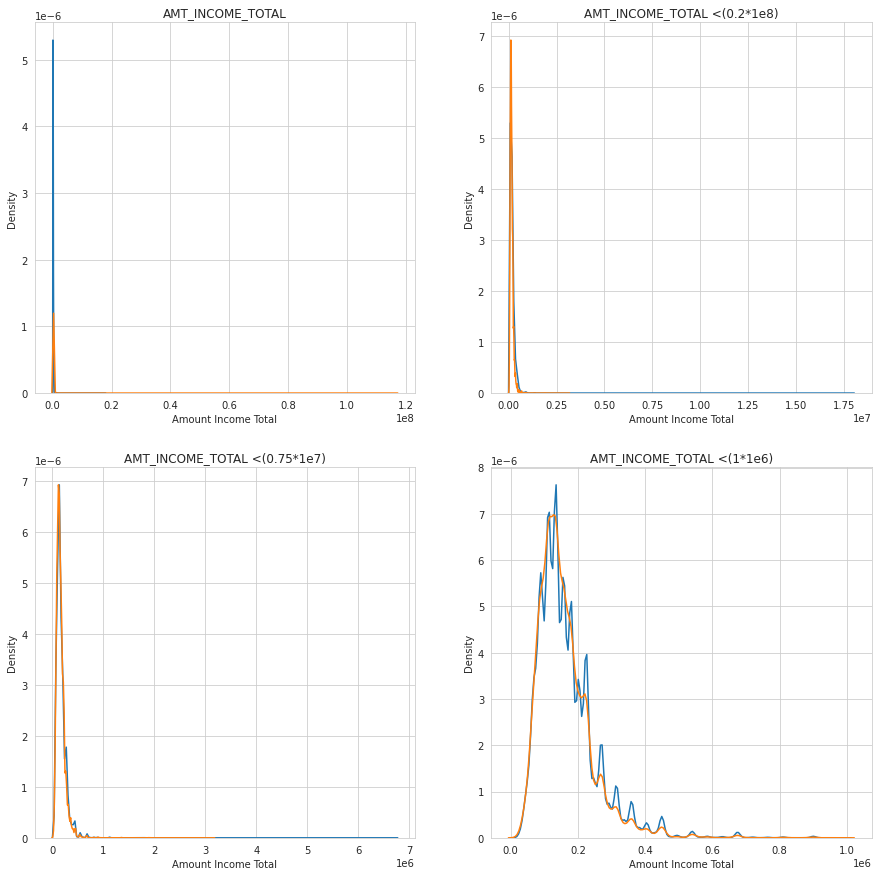

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(15,15))

axes[0,0].title.set_text('AMT_INCOME_TOTAL')
axes[0,0].set_xlabel('Amount Income Total')
axes[0,0].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AMT_INCOME_TOTAL'] , label = 'target == 0',ax=axes[0,0])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AMT_INCOME_TOTAL'] , label = 'target == 1',ax=axes[0,0])

axes[0,1].title.set_text('AMT_INCOME_TOTAL <(0.2*1e8)')
axes[0,1].set_xlabel('Amount Income Total')
axes[0,1].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(0.2*1e8)), 'AMT_INCOME_TOTAL'] , label = 'target == 0',ax=axes[0,1])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(0.2*1e8)), 'AMT_INCOME_TOTAL'] , label = 'target == 1',ax=axes[0,1])

axes[1,0].title.set_text('AMT_INCOME_TOTAL <(0.75*1e7)')
axes[1,0].set_xlabel('Amount Income Total')
axes[1,0].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(0.75*1e7)), 'AMT_INCOME_TOTAL'] , label = 'target == 0',ax=axes[1,0])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(0.75*1e7)), 'AMT_INCOME_TOTAL'] , label = 'target == 1',ax=axes[1,0])

axes[1,1].title.set_text('AMT_INCOME_TOTAL <(1*1e6)')
axes[1,1].set_xlabel('Amount Income Total')
axes[1,1].set_ylabel('Density')
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 0) & (app_train['AMT_INCOME_TOTAL']<(1*1e6)), 'AMT_INCOME_TOTAL'] , label = 'target == 0',ax=axes[1,1])
sns.kdeplot(app_train.loc[(app_train['TARGET'] == 1) & (app_train['AMT_INCOME_TOTAL']<(1*1e6)), 'AMT_INCOME_TOTAL'] , label = 'target == 1',ax=axes[1,1])

In [ ]:
app_train[app_train['AMT_INCOME_TOTAL']>(0.2*1e8)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922,-6762.0,-3643,NaN,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,14,0,0,0,0,0,0,...,NaN,0.0626,NaN,NaN,NaN,block of flats,0.0715,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


<h4>Analysis:</h4>

* AMT_INCOME_TOTAL is the income of the client.
* The income of both type of clients is less than 20000000.0 except one client who has in come of 117000000.0 and still is not able to pay loan.
* If we remove it and plot a graph of AMT_INCOME_TOTAL <(0.2X1e8) we removed the one outlier but we can't clearly make out wheater the majority of both classes are overlapping or not.
* After drawing AMT_INCOME_TOTAL<(1X1e6) it is clear that majority values are highly overlapping for both classes

<h4>Conclusion:</h4>

* Since the majority values of this features in both classes are ovelapping this feature is not of much use.

<h3>Ploting the days employed (In years)</h3>

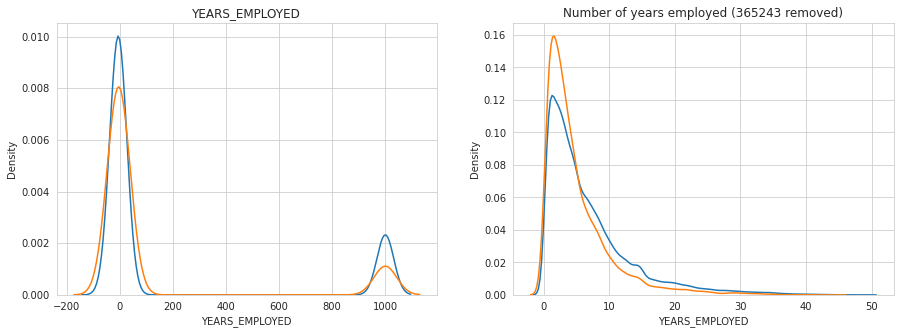

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15, 5))

app_train['YEARS_EMPLOYED']=(app_train['DAYS_EMPLOYED'])/365

axes[0].title.set_text('YEARS_EMPLOYED')
axes[0].set_xlabel('YEARS_EMPLOYED')
axes[0].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_EMPLOYED'] , label = 'target == 0',ax=axes[0])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_EMPLOYED'] , label = 'target == 1',ax=axes[0])

#Replacing the outlier with np.nan
app_train["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['YEARS_EMPLOYED']=(-app_train['DAYS_EMPLOYED'])/365

axes[1].title.set_text('Number of years employed (365243 removed)')
axes[1].set_xlabel('YEARS_EMPLOYED')
axes[1].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_EMPLOYED'] , label = 'target == 0',ax=axes[1])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_EMPLOYED'] , label = 'target == 1',ax=axes[1])


<h4>Analysis:</h4>

* After plotting number of years employed, there are some clients in both target who are working for 1000 years which are outlier.
* After removing the value 365243 in number of days employed now the maximum number of years a person has worked is 50 years.
* It is visible that the density  of clients who have less than 10 years of experience had difficulties in repaying loan.

<h4>Conclusion:</h4>

* There is a slight less overlapping in the maximum density of two target values .
* So this feature will be useful.

<h3>Ploting the days_birth (In years)</h3>

Text(0.5, 0, 'Age')

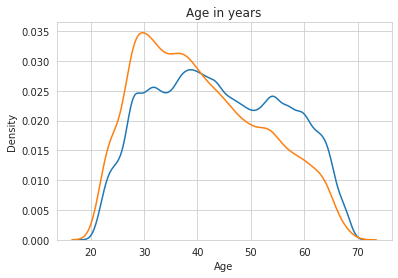

In [ ]:
app_train['AGE_YEARS']=(-app_train['DAYS_BIRTH'])/365
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AGE_YEARS'] , label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AGE_YEARS'] , label = 'target == 1')
plt.title('Age in years')
plt.ylabel('Density')
plt.xlabel('Age')

<h4>Analysis</h4>

* There is a majority of young age goup between (20-40) are having difficulty in repaying loan.
* As the age increases we see age group (50-70) have majority of paying the loan back.

<h4>Conclusion:</h4>

* There is a slight less overlapping in the maximum density of two target values .
* So this feature will be useful.

<h3>Lets see the number of document submitted by a person who was able to pay loan and who wasn't</h3>

In [ ]:
 app_train['DOCUMNNET_COUNT']=(app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)

In [ ]:
app_train_0=app_train[app_train['TARGET']==0]
app_train_0['DOCUMNNET_COUNT'].value_counts()

1    247239
0     27917
2      7383
3       147
Name: DOCUMNNET_COUNT, dtype: int64

In [ ]:
app_train_1=app_train[app_train['TARGET']==1]
app_train_1['DOCUMNNET_COUNT'].value_counts()

1    22817
0     1632
2      359
3       16
4        1
Name: DOCUMNNET_COUNT, dtype: int64

There is one person who has difficulty in paying loan submits only one document

In [ ]:
(app_train[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=0)

FLAG_DOCUMENT_2         13
FLAG_DOCUMENT_3     218340
FLAG_DOCUMENT_4         25
FLAG_DOCUMENT_5       4648
FLAG_DOCUMENT_6      27078
FLAG_DOCUMENT_7         59
FLAG_DOCUMENT_8      25024
FLAG_DOCUMENT_9       1198
FLAG_DOCUMENT_10         7
FLAG_DOCUMENT_11      1203
FLAG_DOCUMENT_12         2
FLAG_DOCUMENT_13      1084
FLAG_DOCUMENT_14       903
FLAG_DOCUMENT_15       372
FLAG_DOCUMENT_16      3053
FLAG_DOCUMENT_17        82
FLAG_DOCUMENT_18      2500
FLAG_DOCUMENT_19       183
FLAG_DOCUMENT_20       156
FLAG_DOCUMENT_21       103
dtype: int64

Text(0.5, 1.0, 'Flag 3 document count')

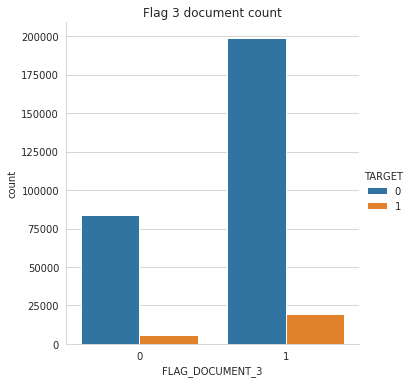

In [ ]:
sns.catplot(x="FLAG_DOCUMENT_3", kind="count",hue='TARGET', data=app_train)
plt.title('Flag 3 document count')

<h4>Analysis</h4>

* Both type of clients mostly submit only 1 document.
* FLAG_DOCUMENT_3 is the most common document submited by the applicants.
* (FLAG_DOCUMENT_3==1) is mostly submited by the clients who can repay the laon and not submited by the clients who cannot repay the loan but this could be also possible because the data is imbalanced.

<h4>Conclusion</h4>

* So FLAG_DOCUMENT_3 could be a useful feature.

<h3>Check the gender column</h3>

In [ ]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [ ]:
app_test['CODE_GENDER'].unique()

array(['F', 'M'], dtype=object)

<h4>Conclusion</h4>

* We have to removed the CODE_GENDER value 'XNA' because it wasn't present in test data and hence not helpful.

<h3>Organization</h3>

In [ ]:
app_train['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

In [ ]:
app_test['ORGANIZATION_TYPE'].unique()

array(['Kindergarten', 'Self-employed', 'Transport: type 3',
       'Business Entity Type 3', 'Government', 'Industry: type 9',
       'School', 'Trade: type 2', 'XNA', 'Services', 'Bank',
       'Industry: type 3', 'Other', 'Trade: type 6', 'Industry: type 12',
       'Trade: type 7', 'Postal', 'Medicine', 'Housing',
       'Business Entity Type 2', 'Construction', 'Military',
       'Industry: type 4', 'Trade: type 3', 'Legal Services', 'Security',
       'Industry: type 11', 'University', 'Business Entity Type 1',
       'Agriculture', 'Security Ministries', 'Transport: type 2',
       'Industry: type 7', 'Transport: type 4', 'Telecom', 'Emergency',
       'Police', 'Industry: type 1', 'Transport: type 1', 'Electricity',
       'Industry: type 5', 'Hotel', 'Restaurant', 'Advertising', 'Mobile',
       'Trade: type 1', 'Industry: type 8', 'Realtor', 'Cleaning',
       'Industry: type 2', 'Trade: type 4', 'Industry: type 6', 'Culture',
       'Insurance', 'Religion', 'Industry: type 1

<h4>Conclusion</h4>

* We don't need to remove XNA value, since it is present in both train and test data

<h3>EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 (Normalized score from external data source)</h3>

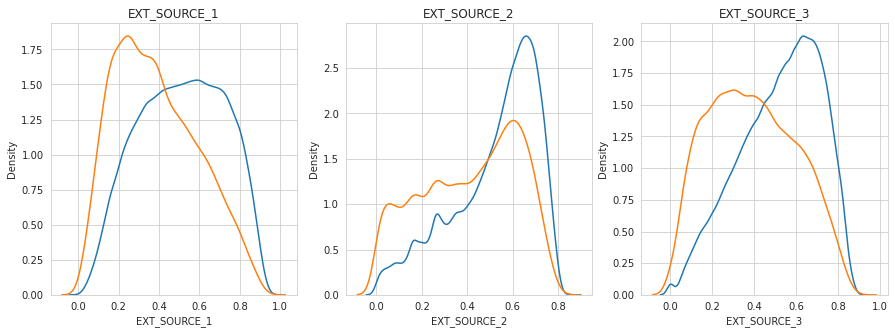

In [ ]:
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(15, 5))

axes[0].title.set_text('EXT_SOURCE_1')
axes[0].set_xlabel('EXT_SOURCE_1')
axes[0].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_1'] , label = 'target == 0',ax=axes[0])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_1'] , label = 'target == 1',ax=axes[0])

axes[1].title.set_text('EXT_SOURCE_2')
axes[1].set_xlabel('EXT_SOURCE_2')
axes[1].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_2'] , label = 'target == 0',ax=axes[1])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_2'] , label = 'target == 1',ax=axes[1])

axes[2].title.set_text('EXT_SOURCE_3')
axes[2].set_xlabel('EXT_SOURCE_3')
axes[2].set_ylabel('Density')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_3'] , label = 'target == 0',ax=axes[2])
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_3'] , label = 'target == 1',ax=axes[2])

<h4>Analysis</h4>

* External source 1 < 0.4 so target=1 and (External source 1 > 0.4 and External source 1 < 0.1) target=0, there is visible seperation between two classes.

* External source 2 < 0.4 so target=1 and (External source 2 > 0.4 and External source 2 < 0.8) target=0, there is visible seperation between two classes.

* External source 3 < 0.4 so target=1 and (External source 3 > 0.4 and External source 3 < 0.1) target=0, there is visible seperation between two classes.

* The values of these features are showing negative colinearity with the target since they are high for target=0 and low for target=1

<h4>Conclusion</h4>

* EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3  These features are very useful

<h3>Pair Plot ('DAYS_EMPLOYED vs DAYS_BIRTH vs AMT_INCOME_TOTAL vs AMT_CREDIT vs AMT_ANNUITY')</h3>

* DAYS_EMPLOYED - How many days before the application the person started current employment
* DAYS_BIRTH - Client's age in days at the time of application
* AMT_INCOME_TOTAL - Income of the client
* AMT_CREDIT - Credit amount of the loan
* AMT_ANNUITY - Loan annuity

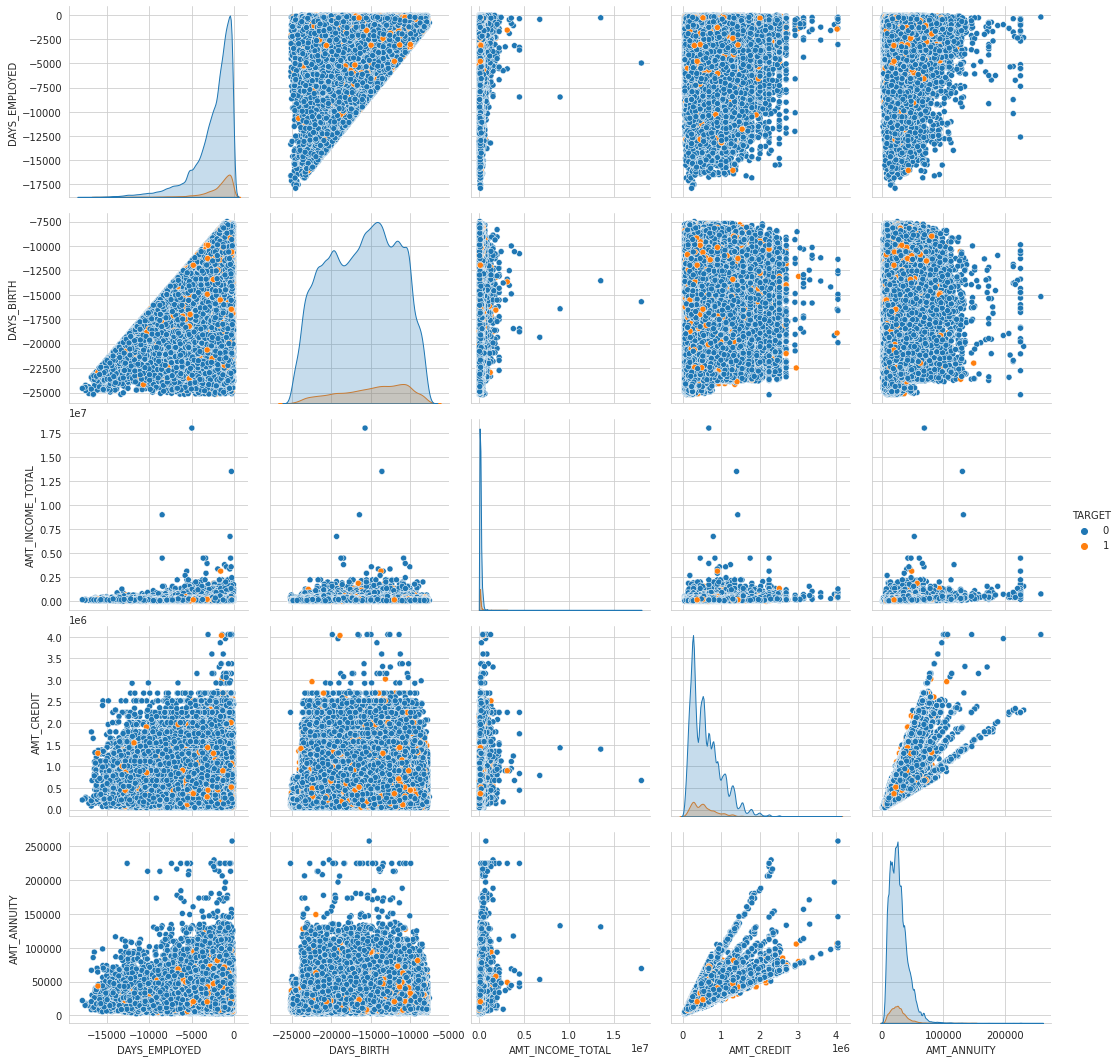

In [ ]:
#remove one outlier in AMT_INCOME_TOTAL
app_train=app_train[app_train['AMT_INCOME_TOTAL']<(0.2*1e8)]
sns.pairplot(app_train, hue="TARGET", height=3,vars=['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']);

In [11]:
def one_hot_encoding_dataframe(df):
    '''
    one hot encoding 
    '''
    original_columns = list(df.columns)
    cat_columns=[x for x in df.columns if df[x].dtype == 'object']
    df=pd.get_dummies(df,columns=cat_columns,dummy_na= False)
    new_added_columns=list(set(df.columns).difference(set(original_columns)))
    return df,new_added_columns,df.columns

In [16]:
def correlation_with_target_top_n(df,n):
    '''
    Calculate the correltation
    '''
    df_corr= df.corr()['TARGET'].sort_values()
    print(n,'Positive Correlations:\n', df_corr.tail(n))
    print('\n',n,' Negative Correlations:\n', df_corr.head(n))
    return df_corr

In [21]:
#corr relation of only train data after adding new features
df_corr=correlation_with_target_top_n(df[df['TARGET'].notnull()],20)

20 Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.042995
FLAG_DOCUMENT_3                                      0.044335
REG_CITY_NOT_LIVE_CITY                               0.044398
ADDRESS_MISSMATCH                                    0.044845
FLAG_EMP_PHONE                                       0.045980
AMT_CREDIT_DAYS_EMPLOYED_PERC                        0.049296
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049816
REG_CITY_NOT_WORK_CITY                               0.050999
DAYS_ID_PUBLISH                                      0.051463
CODE_GENDER_M                                        0.054719
DAYS_LAST_PHONE_CHANGE                               0.055208
NAME_INCOME_TYPE_Working                             0.057474
ANNUITY_DAYS_EMPLOYED_PERC                           0.058183
REGION_RATING_CLIENT                                 0.058903
REGION_RATING_CLIENT_W_CITY                          0.060897
GOODS_PRICE_CREDIT_PER                     

# final feature engineering applied on app_train and app_test

In [8]:
def feature_engineering_on_app_train_test():
    
    '''
    final feature engineering applied on app_train and app_test
    
    '''
    
    app_train=pd.read_csv('application_train.csv')
    app_test=pd.read_csv('application_test.csv')
    #we merge the two data frames the preprocessing we on train must also be done on test
    df=app_train.append(app_test).reset_index()
    
    del app_train
    del app_test
    
    gc.collect()
    
    #The XNA value doesn't mean any thing so it is removed from train data
    df=df[df['CODE_GENDER']!='XNA'] 
        
    #we remove this because 365243 is an outlier
    df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
    
    
    #There is an outlier in the train data where AMT_INCOME_TOTAL of a person having highest income had difficulty in paying loan. 
    df=df[df['AMT_INCOME_TOTAL']<(0.2*1e8)]
 
    df['DOCUMNNET_COUNT']=(df[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=1)
    
    
    df['AMT_REQ_CREDIT_BUREAU_HDWMQY']=(df[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']]).sum(axis=1)
    
    
    #Using domain knowledge and Pairplot 
    #pecentage of his life spent working
    df['DAYS_WORKING_PER']=df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['DAYS_UNEMPLOYED']=abs(df['DAYS_BIRTH'])-abs(df['DAYS_EMPLOYED'])
    
    df['GOODS_PRICE_INCOME_TOTAL_PER']=df['AMT_INCOME_TOTAL']/df['AMT_GOODS_PRICE']
    
    df['GOODS_PRICE_CREDIT_PER']=df['AMT_CREDIT']/df['AMT_GOODS_PRICE']
    
    df['GOODS_PRICE_AMT_ANNUITY_PER']=df['AMT_ANNUITY']/df['AMT_GOODS_PRICE']
    
#     df['GOODS_PRICE_EMP']=abs(df['DAYS_EMPLOYED'])/df['AMT_GOODS_PRICE']
    
#     df['AMT_CREDIT_BIRTH']=df['AMT_CREDIT']/abs(df['DAYS_BIRTH']/365)
    
    #percentage income of person and the credit amount
    df['INCOME_CREDIT_PER'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

    #percentage income of person and the credit amount
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS']+1)

    #Amount paid for previous loan application every month decided by the number of day employed
    df['ANNUITY_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED']/ df['AMT_ANNUITY']
    
    df['AMT_CREDIT_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED']/ df['AMT_CREDIT']
    
    #Amount paid for  loan application every month decided by the number of day lived
    df['ANNUITY_DAYS_BIRTH_PERC'] = df['DAYS_BIRTH']/ df['AMT_ANNUITY']

    #Anually paid amount to amount credited
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    df['PAYMENT_RATE_INV'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

    df['PAY_TOWARDS_LOAN'] = df['AMT_INCOME_TOTAL']-df['AMT_ANNUITY']

    # df['AMT_INCOME_TOTAL_FLAG_LOAN_LESS_50'] =(df['AMT_ANNUITY']<=(0.50*df['AMT_INCOME_TOTAL'])).astype(int)
    
    df['MEAN_DEFAULT_SURR']=((df[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']]).sum(axis=1))//4
    
    df['ADDRESS_MISSMATCH']=((df[['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']]).sum(axis=1))
    
    df['MEAN_ENQUIRIES']=((df[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']]).mean(axis=1))
    
    df['CONTACT_REF']=((df[['FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']]).sum(axis=1))
    
    df['MAX_DAYS_SOMETHING_CHANGED']=((df[['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION']]).max(axis=1))
    
    #Creating features from useful features
    df['EXT_SOURCE_MEAN']=(df[['EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).mean(axis=1)
    
    df['EXT_SOURCE_MEDIAN']=(df[['EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).median(axis=1)
    
    df['EXT_SOURCE_MIN']=(df[['EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).min(axis=1)
    
    df['EXT_SOURCE_MAX']=(df[['EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']]).max(axis=1)
    
    
    df,new_cat_columns,all_columns=one_hot_encoding_dataframe(df)
    with open("all_columns_app_train_test.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    
    
    return df

In [20]:
df=feature_engineering_on_app_train_test()

In [ ]:
train_data_df=df[df['TARGET'].notnull()]
train_column=set(train_data_df.columns)-set({'TARGET','index','SK_ID_CURR'})

y_train=train_data_df['TARGET']
X_train=train_data_df[train_column]

train_column=X_train.columns

from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))

del X_train
gc.collect()

ROCAUC Score : 0.8024315069244328


33

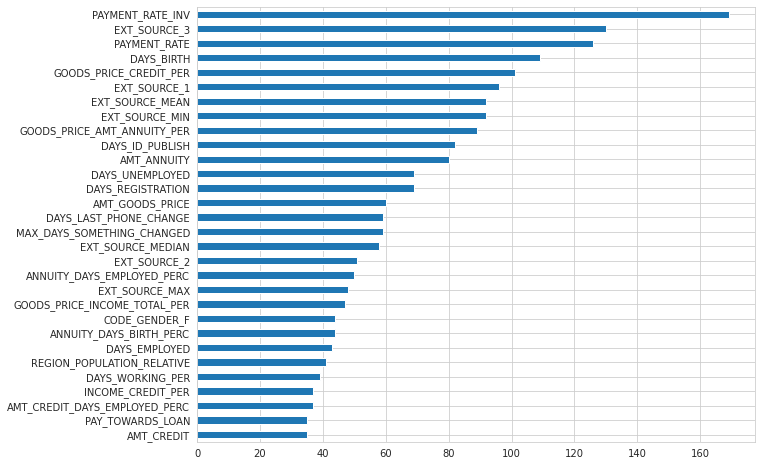

In [ ]:
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

# bureau.csv & bureau_balance.csv

### bureau.csv

* All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
* For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv

* Monthly balances of previous credits in Credit Bureau.
* This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

<h4>bureau_balance.csv</h4>

In [ ]:
bureau_balance_data = pd.read_csv('bureau_balance.csv')

In [ ]:
bureau_balance_data.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
bureau_balance_data['MONTHS_BALANCE'].describe()

count    2.729992e+07
mean    -3.074169e+01
std      2.386451e+01
min     -9.600000e+01
25%     -4.600000e+01
50%     -2.500000e+01
75%     -1.100000e+01
max      0.000000e+00
Name: MONTHS_BALANCE, dtype: float64

In [ ]:
#one hot encoding
bureau_balance_data,bureau_balance_data_cat_columns=one_hot_encoding_dataframe(bureau_balance_data)

In [ ]:
bureau_balance_data.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS_0          0
STATUS_1          0
STATUS_2          0
STATUS_3          0
STATUS_4          0
STATUS_5          0
STATUS_C          0
STATUS_X          0
dtype: int64

In [ ]:
#Aggregate function to be applied on numerical column 
bureau_balance_agg = {'MONTHS_BALANCE': ['min', 'max', 'size','mean','var']}

#Aggregate function to be applied on cat column 
for col in bureau_balance_data_cat_columns:
    bureau_balance_agg[col] = ['mean']
    
bureau_balance_data_agg = bureau_balance_data.groupby('SK_ID_BUREAU').agg(bureau_balance_agg)

In [ ]:
month = -24 
bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
bureau_balance_data_agg['STATUS_12_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].mean()
month = -12 
bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
bureau_balance_data_agg['STATUS_12_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].mean()
month = -9 
bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
bureau_balance_data_agg['STATUS_9_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].mean()
month = -6 
bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
bureau_balance_data_agg['STATUS_6_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].mean()
month = -3 
bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
bureau_balance_data_agg['STATUS_3_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].mean()

In [ ]:
del bureau_balance_data_temp
gc.collect()

70

In [ ]:
bureau_balance_data_agg.head()

MONTHS_BALANCE           ... STATUS_9_C STATUS_6_C STATUS_3_C
                        min max size  ...                                 
SK_ID_BUREAU                          ...                                 
5001709                 -96   0   97  ...        1.0        1.0        1.0
5001710                 -82   0   83  ...        1.0        1.0        1.0
5001711                  -3   0    4  ...        0.0        0.0        0.0
5001712                 -18   0   19  ...        0.9        1.0        1.0
5001713                 -21   0   22  ...        0.0        0.0        0.0

[5 rows x 17 columns]

In [ ]:
#adjust the columns names
modified_col=[]
for c in list(bureau_balance_data_agg.columns):
    modified_col.append(c[0]+"_"+c[1].upper())
bureau_balance_data_agg.columns=modified_col

In [ ]:
bureau_balance_data_agg.head()

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_VAR,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_3_MEAN,STATUS_X_MEAN,STATUS_2_MEAN,STATUS_C_MEAN,STATUS_5_MEAN,STATUS_4_MEAN,STATUS_12_C_,STATUS_9_C_,STATUS_6_C_,STATUS_3_C_
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,-96,0,97,-48.0,792.166667,0.000000,0.0,0.0,0.113402,0.0,0.886598,0.0,0.0,1.000000,1.0,1.0,1.0
5001710,-82,0,83,-41.0,581.000000,0.060241,0.0,0.0,0.361446,0.0,0.578313,0.0,0.0,1.000000,1.0,1.0,1.0
5001711,-3,0,4,-1.5,1.666667,0.750000,0.0,0.0,0.250000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5001712,-18,0,19,-9.0,31.666667,0.526316,0.0,0.0,0.000000,0.0,0.473684,0.0,0.0,0.692308,0.9,1.0,1.0
5001713,-21,0,22,-10.5,42.166667,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


<h4>bureau.csv</h4>

In [ ]:
bureau_data = pd.read_csv('bureau.csv')

In [ ]:
bureau_data.shape

(1716428, 17)

In [ ]:
bureau_data['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [ ]:
#one hot encode the data
bureau_data,bureau_data_cat_columns=one_hot_encoding_dataframe(bureau_data)

In [ ]:
bureau_data_active = bureau_data[bureau_data['CREDIT_ACTIVE_Active'] == 1]

In [ ]:
bureau_data['SEC_LOAN_COUNT']=(bureau_data[['CREDIT_TYPE_Car loan','CREDIT_TYPE_Loan for the purchase of equipment','CREDIT_TYPE_Mortgage','CREDIT_TYPE_Real estate loan','CREDIT_TYPE_Loan for purchase of shares (margin lending)'
                         ]]==1).sum(axis=1)

In [ ]:
bureau_data['UNSEC_LOAN_COUNT']=(bureau_data[[ 'CREDIT_TYPE_Another type of loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Unknown type of loan']]==1).sum(axis=1)

In [ ]:
bureau_data['DEBT_RATIO']=bureau_data['AMT_CREDIT_SUM_DEBT']/bureau_data['AMT_CREDIT_SUM']

In [ ]:
#remove the oulier days "365243"
for col in bureau_data.columns:
    if col.startswith('DAYS'):
        bureau_data[col].replace(365243, np.nan, inplace= True)

#### bureau.csv + bureau_balance.csv using SK_ID_BUREAU

In [ ]:
# bureau_balance_data_agg['SK_ID_BUREAU'] = bureau_balance_data_agg.index
bureau_data = bureau_data.join(bureau_balance_data_agg, how='left', on='SK_ID_BUREAU')
bureau_data.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [ ]:
#mean aggregate
bureau_data_agg={}
for col in bureau_data.columns:
    if col!='SK_ID_CURR':
        bureau_data_agg[col]=['mean']
        if (col=='AMT_CREDIT_SUM_DEBT') | (col=='AMT_CREDIT_SUM_OVERDUE') | (col=='UNSEC_LOAN_COUNT') |(col=='SEC_LOAN_COUNT'):
            bureau_data_agg[col]=['sum']
        if col=='DAYS_CREDIT':
            bureau_data_agg[col]=['min','mean']
        if col=='DEBT_RATIO':
            bureau_data_agg[col]=['sum']

In [ ]:
bureau_agg = bureau_data.groupby('SK_ID_CURR').agg(bureau_data_agg)

In [ ]:
bureau_agg.head()

DAYS_CREDIT               ... STATUS_6_C_ STATUS_3_C_
                   min         mean  ...        mean        mean
SK_ID_CURR                           ...                        
100001           -1572  -735.000000  ...    0.571429    0.571429
100002           -1437  -874.000000  ...    0.500000    0.500000
100003           -2586 -1400.750000  ...         NaN         NaN
100004           -1326  -867.000000  ...         NaN         NaN
100005            -373  -190.666667  ...    0.238095    0.333333

[5 rows x 56 columns]

In [ ]:
#change the column names
modified_col=[]
for c in list(bureau_agg.columns):
    modified_col.append(c[0]+"_"+c[1].upper())
bureau_agg.columns=modified_col

In [ ]:
bureau_agg.head()

,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,CREDIT_DAY_OVERDUE_MEAN,DAYS_CREDIT_ENDDATE_MEAN,DAYS_ENDDATE_FACT_MEAN,AMT_CREDIT_MAX_OVERDUE_MEAN,CNT_CREDIT_PROLONG_MEAN,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_OVERDUE_SUM,DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY_MEAN,CREDIT_ACTIVE_Active_MEAN,CREDIT_ACTIVE_Bad debt_MEAN,CREDIT_ACTIVE_Closed_MEAN,CREDIT_ACTIVE_Sold_MEAN,CREDIT_CURRENCY_currency 1_MEAN,CREDIT_CURRENCY_currency 2_MEAN,CREDIT_CURRENCY_currency 3_MEAN,CREDIT_CURRENCY_currency 4_MEAN,CREDIT_TYPE_Another type of loan_MEAN,CREDIT_TYPE_Car loan_MEAN,CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,CREDIT_TYPE_Consumer credit_MEAN,CREDIT_TYPE_Credit card_MEAN,CREDIT_TYPE_Interbank credit_MEAN,CREDIT_TYPE_Loan for business development_MEAN,CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,CREDIT_TYPE_Loan for the purchase of equipment_MEAN,CREDIT_TYPE_Loan for working capital replenishment_MEAN,CREDIT_TYPE_Microloan_MEAN,CREDIT_TYPE_Mobile operator loan_MEAN,CREDIT_TYPE_Mortgage_MEAN,CREDIT_TYPE_Real estate loan_MEAN,CREDIT_TYPE_Unknown type of loan_MEAN,SEC_LOAN_COUNT_SUM,UNSEC_LOAN_COUNT_SUM,DEBT_RATIO_SUM,MONTHS_BALANCE_MIN_MEAN,MONTHS_BALANCE_MAX_MEAN,MONTHS_BALANCE_SIZE_MEAN,MONTHS_BALANCE_MEAN_MEAN,MONTHS_BALANCE_VAR_MEAN,STATUS_0_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_X_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_C_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_4_MEAN_MEAN,STATUS_12_C__MEAN,STATUS_9_C__MEAN,STATUS_6_C__MEAN,STATUS_3_C__MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,596686.5,0.00000,0.0,-93.142857,3545.357143,0.428571,0.0,0.571429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,1.977625,-23.571429,0.0,24.571429,-11.785714,70.761905,0.336651,0.007519,0.0,0.214590,0.0,0.441240,0.0,0.0,0.571429,0.571429,0.571429,0.571429
100002,-1437,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,245781.0,7997.14125,0.0,-499.875000,0.000000,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,0.546180,-28.250000,-15.5,13.750000,-21.875000,19.854167,0.406960,0.255682,0.0,0.161932,0.0,0.175426,0.0,0.0,0.500000,0.500000,0.500000,0.500000
100003,-2586,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.0,202500.00000,0.0,-816.000000,NaN,0.250000,0.0,0.750000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-1326,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.0,0.00000,0.0,-532.000000,NaN,0.000000,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-373,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,568408.5,0.00000,0.0,-54.333333,1420.500000,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,1.803768,-6.000000,0.0,7.000000,-3.000000,6.222222,0.735043,0.000000,0.0,0.136752,0.0,0.128205,0.0,0.0,0.128205,0.166667,0.238095,0.333333


In [ ]:
bureau_agg['ABS_YEAR_CREDIT_MAX']=abs(bureau_agg['DAYS_CREDIT_MIN']/365)

#### (app_train,app_test)+bureau.csv + bureau_balance.csv using SK_ID_CURR

In [ ]:
df_bureau = df.join(bureau_agg, how='left', on='SK_ID_CURR')

In [ ]:
df_bureau.head()

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,CREDIT_CURRENCY_currency 1_MEAN,CREDIT_CURRENCY_currency 2_MEAN,CREDIT_CURRENCY_currency 3_MEAN,CREDIT_CURRENCY_currency 4_MEAN,CREDIT_TYPE_Another type of loan_MEAN,CREDIT_TYPE_Car loan_MEAN,CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,CREDIT_TYPE_Consumer credit_MEAN,CREDIT_TYPE_Credit card_MEAN,CREDIT_TYPE_Interbank credit_MEAN,CREDIT_TYPE_Loan for business development_MEAN,CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,CREDIT_TYPE_Loan for the purchase of equipment_MEAN,CREDIT_TYPE_Loan for working capital replenishment_MEAN,CREDIT_TYPE_Microloan_MEAN,CREDIT_TYPE_Mobile operator loan_MEAN,CREDIT_TYPE_Mortgage_MEAN,CREDIT_TYPE_Real estate loan_MEAN,CREDIT_TYPE_Unknown type of loan_MEAN,SEC_LOAN_COUNT_SUM,UNSEC_LOAN_COUNT_SUM,DEBT_RATIO_SUM,MONTHS_BALANCE_MIN_MEAN,MONTHS_BALANCE_MAX_MEAN,MONTHS_BALANCE_SIZE_MEAN,MONTHS_BALANCE_MEAN_MEAN,MONTHS_BALANCE_VAR_MEAN,STATUS_0_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_X_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_C_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_4_MEAN_MEAN,STATUS_12_C__MEAN,STATUS_9_C__MEAN,STATUS_6_C__MEAN,STATUS_3_C__MEAN,ABS_YEAR_CREDIT_MAX
0,0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.54618,-28.25,-15.5,13.75,-21.875,19.854167,0.40696,0.255682,0.0,0.161932,0.0,0.175426,0.0,0.0,0.5,0.5,0.5,0.5,3.936986
1,1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.084932
2,2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.632877
3,3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.147945


In [ ]:
df_corr=correlation_with_target_top_n(df_bureau[df_bureau['TARGET'].notnull()],20)

20 Positive Correlations:
 DAYS_ID_PUBLISH                0.051463
DAYS_ENDDATE_FACT_MEAN         0.053204
CODE_GENDER_M                  0.054719
DAYS_LAST_PHONE_CHANGE         0.055208
NAME_INCOME_TYPE_Working       0.057474
ANNUITY_DAYS_EMPLOYED_PERC     0.058183
REGION_RATING_CLIENT           0.058903
REGION_RATING_CLIENT_W_CITY    0.060897
STATUS_1_MEAN_MEAN             0.061183
DAYS_CREDIT_UPDATE_MEAN        0.068922
GOODS_PRICE_CREDIT_PER         0.069426
MAX_DAYS_SOMETHING_CHANGED     0.073441
DAYS_EMPLOYED                  0.074950
DAYS_CREDIT_MIN                0.075241
MONTHS_BALANCE_MEAN_MEAN       0.076424
CREDIT_ACTIVE_Active_MEAN      0.077344
DAYS_BIRTH                     0.078235
MONTHS_BALANCE_MIN_MEAN        0.089038
DAYS_CREDIT_MEAN               0.089718
TARGET                         1.000000
Name: TARGET, dtype: float64

 20  Negative Correlations:
 EXT_SOURCE_MEAN                        -0.222040
EXT_SOURCE_MEDIAN                      -0.218100
EXT_SOURCE_MAX  

### DAYS_CREDIT_MEAN 

* The mean number of days before current application did client apply for Credit Bureau credit

Text(0.5, 0, 'Credit Days')

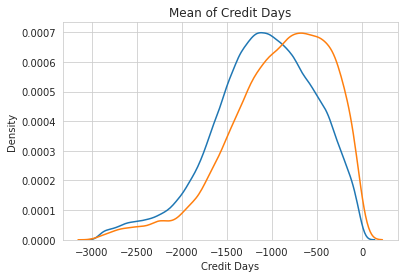

In [ ]:
sns.kdeplot(df_bureau.loc[df_bureau['TARGET']==0,'DAYS_CREDIT_MEAN'],label='target==0')
sns.kdeplot(df_bureau.loc[df_bureau['TARGET']==1,'DAYS_CREDIT_MEAN'],label='target==1')
plt.title('Mean of Credit Days')
plt.ylabel('Density')
plt.xlabel('Credit Days')

#### Analysis

* If the mean days are less than -1000 then target==0 (can repay the loan)
* If the mean days are greater than -1000 then target==1 (cannot repay the loan)
* The feature DAYS_CREDIT_MEAN is showing positive coorelation because days here are negative else the coorelation would be negative

#### Conclusion

* The feature DAYS_CREDIT_MEAN is very useful.

# final feature engineering applied on bureau and bureau_balance

In [7]:
def feature_engineering_on_bureau_data_balance():
    
    '''
    final feature engineering applied on bureau and bureau_balance
    
    '''
    
    bureau_balance_data = pd.read_csv('bureau_balance.csv')
    bureau_balance_data,bureau_balance_data_cat_columns,all_columns=one_hot_encoding_dataframe(bureau_balance_data)
    with open("all_columns_bureau_data_balance.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    #Aggregate function to be applied on numerical column 
    bureau_balance_agg = {'MONTHS_BALANCE': ['min', 'max','sum']}

    #Aggregate function to be applied on cat column 
    for col in bureau_balance_data_cat_columns:
        if (col!='SK_BUREAU_ID'):
            bureau_balance_agg[col] = ['mean']

    bureau_balance_data_agg = bureau_balance_data.groupby(['SK_ID_BUREAU']).agg(bureau_balance_agg)
    
    
     
    
    
    month = -60 
    bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
    bureau_balance_data_agg['STATUS_60_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].sum()
    month = -48 
    bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
    bureau_balance_data_agg['STATUS_48_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].sum()
    month = -36 
    bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
    bureau_balance_data_agg['STATUS_36_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].sum()
    month = -24 
    bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
    bureau_balance_data_agg['STATUS_24_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].sum()
    month = -12 
    bureau_balance_data_temp = bureau_balance_data[bureau_balance_data.MONTHS_BALANCE >= month].copy()
    bureau_balance_data_agg['STATUS_12_C'] = bureau_balance_data_temp.groupby('SK_ID_BUREAU')['STATUS_C'].sum()
    
    
    
    
   
    del bureau_balance_data_temp
    
    gc.collect()


    
    modified_col=[]
    for c in list(bureau_balance_data_agg.columns):
        if (c!='SK_BUREAU_ID'):
            modified_col.append(c[0]+"_"+c[1].upper())
    bureau_balance_data_agg.columns=modified_col

#     bureau_balance_data_agg.rename(columns={"SK_ID_BUREAU_": "SK_ID_BUREAU"})
    
    bureau_data = pd.read_csv('bureau.csv')
    
    bureau_data,bureau_data_cat_columns,all_columns=one_hot_encoding_dataframe(bureau_data)
    with open("all_columns_bureau_data.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    bureau_data['SEC_LOAN_COUNT']=(bureau_data[['CREDIT_TYPE_Car loan','CREDIT_TYPE_Loan for the purchase of equipment','CREDIT_TYPE_Mortgage','CREDIT_TYPE_Real estate loan','CREDIT_TYPE_Loan for purchase of shares (margin lending)'
                         ]]==1).sum(axis=1)
    
    bureau_data['UNSEC_LOAN_COUNT']=(bureau_data[[ 'CREDIT_TYPE_Another type of loan',
       'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit',
       'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for working capital replenishment',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan',
       'CREDIT_TYPE_Unknown type of loan']]==1).sum(axis=1)
    
    
    bureau_data['DEBT_PER']=bureau_data['AMT_CREDIT_SUM_DEBT']/bureau_data['AMT_CREDIT_SUM']
    
    bureau_data['AMT_ANNUITY_AMT_CREDIT_SUM_PER']=bureau_data['AMT_ANNUITY']/bureau_data['AMT_CREDIT_SUM']
    
    bureau_data['DEBT_LIMIT_PER']=bureau_data['AMT_CREDIT_SUM_DEBT']/bureau_data['AMT_CREDIT_SUM_LIMIT']
    
    bureau_data['B_EXTRA_PAY'] = bureau_data['AMT_ANNUITY']-bureau_data['AMT_CREDIT_SUM']
    
    for col in bureau_data.columns:
        if col.startswith('DAYS'):
            bureau_data[col].replace(365243, np.nan, inplace= True)
            
    
    bureau_data = bureau_data.join(bureau_balance_data_agg, how='left', on=['SK_ID_BUREAU'])
    
    
#     print(bureau_data.columns)
    
    bureau_data_agg={}
    for col in bureau_data.columns:
        if (col!='SK_ID_CURR' or col!='SK_BUREAU_ID'):
            bureau_data_agg[col]=['mean']
            if (col=='AMT_CREDIT_SUM_DEBT') | (col=='AMT_CREDIT_SUM_OVERDUE') | (col=='UNSEC_LOAN_COUNT') |(col=='SEC_LOAN_COUNT'):
                bureau_data_agg[col]=['sum']
            if col=='DAYS_CREDIT':
                bureau_data_agg[col]=['min']
            if col=='DEBT_PER':
                bureau_data_agg[col]=['mean']
    
   
            
    bureau_agg = bureau_data.groupby('SK_ID_CURR').agg(bureau_data_agg)
    
    modified_col=[]
    for c in list(bureau_agg.columns):
        modified_col.append(c[0]+"_"+c[1].upper())
    bureau_agg.columns=modified_col
    
    bureau_agg['ABS_YEAR_CREDIT_MAX']=abs(bureau_agg['DAYS_CREDIT_MIN']/365)
    
    bureau_agg['AMT_CREDIT_MAX_OVERDUE_MAX'] = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max()
    
    bureau_agg['BEAU_COUNT'] = bureau_data.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
    
#     bureau_agg.drop(['SK_ID_BUREAU_MEAN','SK_ID_CURR_MEAN'], axis=1, inplace= True)
    
     
#     #######################################
    
    bureau_data_active = bureau_data[bureau_data['CREDIT_ACTIVE_Active'] == 1]
    
    bureau_agg['B_ACT_AMT_CREDIT_SUM_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean()
    bureau_agg['B_ACT_AMT_CREDIT_SUME_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].min()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].max()
    
    bureau_agg['B_ACT_AMT_CREDIT_MAX_OVERDUE_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()
    bureau_agg['B_ACT_AMT_CREDIT_MAX_OVERDUE_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].min()
    bureau_agg['B_ACT_AMT_CREDIT_MAX_OVERDUE_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max()
        
    bureau_agg['B_ACT_AMT_CREDIT_SUM_DEBT_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].mean()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_DEBT_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].min()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_DEBT_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].max()
    
    bureau_agg['B_ACT_AMT_CREDIT_SUM_LIMIT_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].mean()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_LIMIT_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].min()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_LIMIT_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].max()
    
    bureau_agg['B_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_OVERDUE_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].min()
    bureau_agg['B_ACT_AMT_CREDIT_SUM_OVERDUE_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].max()
    
    
    
    bureau_agg['B_ACT_DAYS_CREDIT_ENDDATE_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].mean()
    bureau_agg['B_ACT_DAYS_CREDIT_ENDDATE_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].min()
    bureau_agg['B_ACT_DAYS_CREDIT_ENDDATE_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
    
    bureau_agg['B_ACT_CREDIT_DAY_OVERDUE_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean()
    bureau_agg['B_ACT_CREDIT_DAY_OVERDUE_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].min()
    bureau_agg['B_ACT_CREDIT_DAY_OVERDUE_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max()
    
    
    bureau_agg['B_ACT_DAYS_CREDIT_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()
    bureau_agg['B_ACT_DAYS_CREDIT_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
    bureau_agg['B_ACT_DAYS_CREDIT_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
    
    
    bureau_agg['B_ACT_DAYS_ENDDATE_FACT_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].mean()
    bureau_agg['B_ACT_DAYS_ENDDATE_FACT_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].min()
    bureau_agg['B_ACT_DAYS_ENDDATE_FACT_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].max()
    
#     bureau_agg['ACT_DAYS_CREDIT_UPDATE_MEAN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].mean()
#     bureau_agg['ACT_DAYS_CREDIT_UPDATE_MIN'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].min()
#     bureau_agg['ACT_DAYS_CREDIT_UPDATE_MAX'] = bureau_data_active.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].max()
    
    
    ####################################
    
    bureau_data_closed = bureau_data[bureau_data['CREDIT_ACTIVE_Closed'] == 1]
    
    bureau_agg['B_CLO_AMT_CREDIT_SUM_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].mean()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].min()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].max()
    
    bureau_agg['B_CLO_AMT_CREDIT_MAX_OVERDUE_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].mean()
    bureau_agg['B_CLO_AMT_CREDIT_MAX_OVERDUE_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].min()
    bureau_agg['B_CLO_AMT_CREDIT_MAX_OVERDUE_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].max()
        
    bureau_agg['B_CLO_AMT_CREDIT_SUM_DEBT_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].mean()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_DEBT_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].min()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_DEBT_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].max()
    
    bureau_agg['B_CLO_AMT_CREDIT_SUM_LIMIT_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].mean()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_LIMIT_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].min()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_LIMIT_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].max()
    
    bureau_agg['B_CLO_AMT_CREDIT_SUM_OVERDUE_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].mean()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_OVERDUE_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].min()
    bureau_agg['B_CLO_AMT_CREDIT_SUM_OVERDUE_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].max()
    
    
    
    bureau_agg['B_CLO_DAYS_CREDIT_ENDDATE_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].mean()
    bureau_agg['B_CLO_DAYS_CREDIT_ENDDATE_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].min()
    bureau_agg['B_CLO_DAYS_CREDIT_ENDDATE_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
    
    bureau_agg['B_CLO_CREDIT_DAY_OVERDUE_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean()
    bureau_agg['B_CLO_CREDIT_DAY_OVERDUE_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].min()
    bureau_agg['B_CLO_CREDIT_DAY_OVERDUE_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max()
    
    
    bureau_agg['B_CLO_DAYS_CREDIT_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()
    bureau_agg['B_CLO_DAYS_CREDIT_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
    bureau_agg['B_CLO_DAYS_CREDIT_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()
    
    
    bureau_agg['B_CLO_DAYS_ENDDATE_FACT_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].mean()
    bureau_agg['B_CLO_DAYS_ENDDATE_FACT_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].min()
    bureau_agg['B_CLO_DAYS_ENDDATE_FACT_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].max()
    
    
#     bureau_agg['CLO_DAYS_CREDIT_UPDATE_MEAN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].mean()
#     bureau_agg['CLO_DAYS_CREDIT_UPDATET_MIN'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].min()
#     bureau_agg['CLO_DAYS_CREDIT_UPDATE_MAX'] = bureau_data_closed.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].max()
    
    
    bureau_agg.drop(['SK_ID_CURR_MEAN'], axis=1, inplace= True)
    bureau_agg.drop(['SK_ID_BUREAU_MEAN'], axis=1, inplace= True)
  
#     print(modified_col)
    
    
    del bureau_data,bureau_data_closed,bureau_data_active
    del bureau_balance_data
    
    gc.collect()
    
    return bureau_agg
    

In [ ]:
df_bureau=feature_engineering_on_bureau_data_balance()
df_bureau =df.join(df_bureau, how='left', on='SK_ID_CURR')
df_bureau=df_bureau[df_bureau['TARGET'].notnull()]

y_train=df_bureau['TARGET']
train_column=set(df_bureau.columns)-set(df.columns)
# train_column=train_column-set({'SK_ID_BUREAU_MEAN','SK_ID_CURR_MEAN'})
X_train=df_bureau[train_column]

train_column=X_train.columns
X_train=X_train.replace([np.inf, -np.inf],np.nan)
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)
scaler = MinMaxScaler(feature_range = (0, 1))
X_train=scaler.fit_transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))


ROCAUC Score : 0.7224592125941772


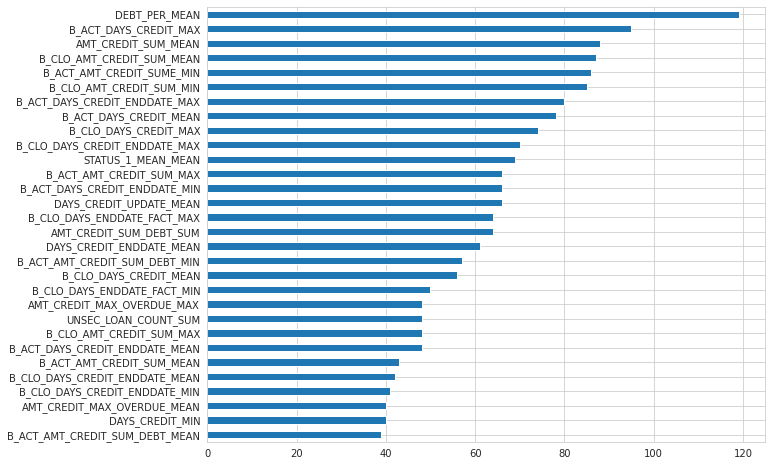

In [ ]:
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

# previous_application.csv

### previous_application.csv

* All previous applications for Home Credit loans of clients who have loans in our sample.There is one row for each previous application related to loans in our data sample.

In [ ]:
prev_data = pd.read_csv('previous_application.csv')

In [ ]:
prev_data.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_data['RATE_INTEREST_PRIMARY'].notnull().sum()

5951

In [ ]:
prev_data['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [ ]:
prev_data['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

In [ ]:
prev_data['EXTRA_AMT_PAID'] = prev_data['CNT_PAYMENT']*prev_data['AMT_ANNUITY'] - prev_data['AMT_CREDIT']

In [ ]:
prev_data['Amount_credit_accepted']=prev_data['AMT_CREDIT']
prev_data.loc[prev_data['CODE_REJECT_REASON']!='XAP','Amount_credit_accepted']=0

In [ ]:
prev_data['Amount_credit_rejected']=prev_data['AMT_CREDIT']
prev_data.loc[prev_data['CODE_REJECT_REASON']=='XAP','Amount_credit_rejected']=0

In [ ]:
prev_data['PREV_APP_XAP']=((prev_data['CODE_REJECT_REASON']=='XAP')).astype(int)

In [ ]:
prev_data,prev_data_cat_columns=one_hot_encoding_dataframe(prev_data)

In [ ]:
#remove the outlier 365243
for col in prev_data.columns:
    if col.startswith('DAYS'):
        prev_data[col].replace(365243, np.nan, inplace= True)

In [ ]:
#Aggregation to apply
prev_data_agg={}
for col in prev_data.columns:
    if col!='SK_ID_CURR':
        prev_data_agg[col]=['mean']

In [ ]:
#Applying Aggregation
prev_agg = prev_data.groupby('SK_ID_CURR').agg(prev_data_agg)

In [ ]:
prev_agg.head()

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,EXTRA_AMT_PAID,Amount_credit_accepted,Amount_credit_rejected,PREV_APP_XAP,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT_N,FLAG_LAST_APPL_PER_CONTRACT_Y,NAME_CASH_LOAN_PURPOSE_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_Business development,NAME_CASH_LOAN_PURPOSE_Buying a garage,...,CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_SELLER_INDUSTRY_Auto technology,NAME_SELLER_INDUSTRY_Clothing,NAME_SELLER_INDUSTRY_Connectivity,NAME_SELLER_INDUSTRY_Construction,NAME_SELLER_INDUSTRY_Consumer electronics,NAME_SELLER_INDUSTRY_Furniture,NAME_SELLER_INDUSTRY_Industry,NAME_SELLER_INDUSTRY_Jewelry,NAME_SELLER_INDUSTRY_MLM partners,NAME_SELLER_INDUSTRY_Tourism,NAME_SELLER_INDUSTRY_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1.369693e+06,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,NaN,-1740.0,23.0,8.0,NaN,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000,7821.00,23787.00,0.0,1.0,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.038818e+06,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,NaN,-565.000000,125.000000,-25.000000,-17.000000,0.000000,42987.60,179055.00,0.0,1.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
100003,2.281150e+06,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,NaN,-1305.0,533.0,10

In [ ]:
#modify columns name
modified_col=[]

for c in list(prev_agg.columns):
    modified_col.append("PREV_"+c[0]+"_"+c[1].upper())
prev_agg.columns=modified_col

In [ ]:
prev_agg.head()

,PREV_SK_ID_PREV_MEAN,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MEAN,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_NFLAG_LAST_APPL_IN_DAY_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_DAYS_DECISION_MEAN,PREV_SELLERPLACE_AREA_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_TERMINATION_MEAN,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_EXTRA_AMT_PAID_MEAN,PREV_Amount_credit_accepted_MEAN,PREV_Amount_credit_rejected_MEAN,PREV_PREV_APP_XAP_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,...,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country-wide_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional / Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,1.369693e+06,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,NaN,-1740.0,23.0,8.0,NaN,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000,7821.00,23787.00,0.0,1.0,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.038818e+06,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,NaN,-565.000000,125.000000,-25.000000,-17.000000,0.000000,42987.60,179055.00,0.0,1.0,0.000000,1.000000,0.0,0.0,

#### (app_train,app_test)+previous_application.csv using SK_ID_CURR

In [ ]:
df_prev = df.join(prev_agg, how='left', on='SK_ID_CURR')
df_prev.head()

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN,PREV_CHANNEL_TYPE_Contact center_MEAN,PREV_CHANNEL_TYPE_Country-wide_MEAN,PREV_CHANNEL_TYPE_Credit and cash offices_MEAN,PREV_CHANNEL_TYPE_Regional / Local_MEAN,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_SELLER_INDUSTRY_Auto technology_MEAN,PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN,PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN,PREV_NAME_SELLER_INDUSTRY_Construction_MEAN,PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN
0,0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0
1,1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,...,0.0,0.0,0.0,0.333333,0.333333,0.000000,0.333333,0.0,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0
2,2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0
3,3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,Na

In [ ]:
#Let us look at the coorelation of our newly added feature with the TARGET
df_corr=correlation_with_target_top_n(df_prev[df_prev['TARGET'].notnull()],20)

20 Positive Correlations:
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049816
REG_CITY_NOT_WORK_CITY                               0.050999
DAYS_ID_PUBLISH                                      0.051463
PREV_CODE_REJECT_REASON_HC_MEAN                      0.054548
CODE_GENDER_M                                        0.054719
DAYS_LAST_PHONE_CHANGE                               0.055208
PREV_CODE_REJECT_REASON_SCOFR_MEAN                   0.055869
PREV_NAME_PRODUCT_TYPE_walk-in_MEAN                  0.057418
NAME_INCOME_TYPE_Working                             0.057474
ANNUITY_DAYS_EMPLOYED_PERC                           0.058183
REGION_RATING_CLIENT                                 0.058903
REGION_RATING_CLIENT_W_CITY                          0.060897
GOODS_PRICE_CREDIT_PER                               0.069426
MAX_DAYS_SOMETHING_CHANGED                           0.073441
DAYS_EMPLOYED                                        0.074950
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     

### PREV_DAYS_FIRST_DRAWING_MEAN

* Mean value of clients all other previous applications relative to application date of current application when was the first disbursement of the previous application 

* A disbursement is a form of payment from a public or dedicated fund. Alternatively, it means a payment made on behalf of a client to a third party for which reimbursement is subsequently sought from the client.

Text(0.5, 0, 'PREV_DAYS_FIRST_DRAWING_MEAN')

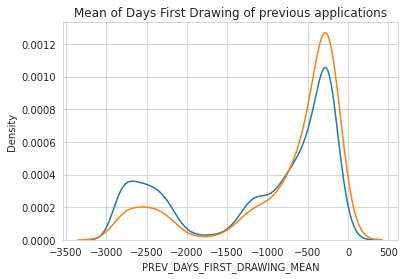

In [ ]:
sns.kdeplot(df_prev.loc[df_prev['TARGET']==0,'PREV_DAYS_FIRST_DRAWING_MEAN'],label='target==0')
sns.kdeplot(df_prev.loc[df_prev['TARGET']==1,'PREV_DAYS_FIRST_DRAWING_MEAN'],label='target==1')
plt.title('Mean of Days First Drawing of previous applications')
plt.ylabel('Density')
plt.xlabel('PREV_DAYS_FIRST_DRAWING_MEAN')

#### Analysis

* The Mean of Days of first darwing for previous application for days less than -2000 is target=0
* The Mean of Days of first darwing for previous application for days greater than -500 is target=1 
* Between -2000 and -500 you see equal chances of both targets classes to happen


#### Conclusion

* PREV_DAYS_FIRST_DRAWING_MEAN is a very useful feature

### PREV_PREV_APP_XAP_MEAN                    

* Mean number of previous approved applications.

Text(0.5, 0, 'PREV_PREV_APP_XAP_MEAN')

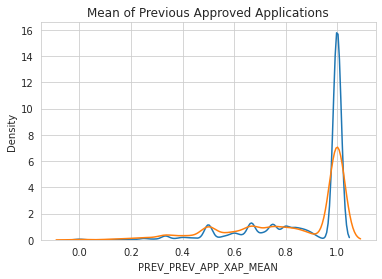

In [ ]:
sns.kdeplot(df_prev.loc[df_prev['TARGET']==0,'PREV_PREV_APP_XAP_MEAN'],label='target==0')
sns.kdeplot(df_prev.loc[df_prev['TARGET']==1,'PREV_PREV_APP_XAP_MEAN'],label='target==1')
plt.title('Mean of Previous Approved Applications')
plt.ylabel('Density')
plt.xlabel('PREV_PREV_APP_XAP_MEAN')

#### Analysis

* The Mean of previous approved application for target=0 is mostly around 1
* But if see the target=0 and target=1 peak curve target=0 curve is more peaked then target=1

#### Conclusion

* PREV_PREV_APP_XAP_MEAN  is  a useful feature shows a strong negative coorelation with target

### PREV_Amount_credit_accepted_MEAN

* Mean amount of previous accepted applicat

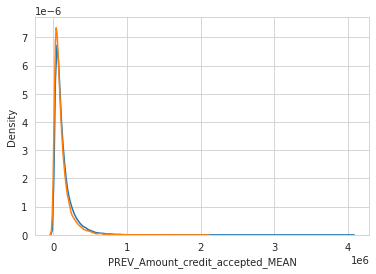

In [ ]:
sns.kdeplot(df_prev.loc[df_prev['TARGET']==0,'PREV_Amount_credit_accepted_MEAN'],label='target==0')
sns.kdeplot(df_prev.loc[df_prev['TARGET']==1,'PREV_Amount_credit_accepted_MEAN'],label='target==1')

#### Analysis

* There is slight difference in the peaks of both the curves
* Also if value is greater then 2X1e6 is then it is target 0

#### Conclusion

* PREV_Amount_credit_accepted_MEAN is a useful feature shows a negative coorelation.

# final feature engineering applied on previous_application

In [6]:
def feature_engineering_on_previous_application():
    
    '''
    final feature engineering applied on previous_application
    
    '''
    
    
    prev_data = pd.read_csv('previous_application.csv')
    
    prev_data['EXTRA_AMT_PAID'] = prev_data['CNT_PAYMENT']*prev_data['AMT_ANNUITY']-prev_data['AMT_CREDIT']
    
    prev_data['AMT_LEFT_TO_PAY'] = prev_data['CNT_PAYMENT']*prev_data['AMT_ANNUITY']-prev_data['AMT_DOWN_PAYMENT']
    
#     prev_data['PER_MONTH_CNT_PAYMENT']=prev_data['CNT_PAYMENT']/12
    
    #https://www.calculatorsoup.com/calculators/financial/simple-interest-plus-principal-calculator.php
    prev_data['RATE_OF_INTREST'] = (1/prev_data['CNT_PAYMENT'])*(((prev_data['CNT_PAYMENT']*prev_data['AMT_ANNUITY'])/prev_data['AMT_CREDIT'])-1)
    
    prev_data['SIMPLE_INTREST']= (prev_data['AMT_CREDIT']*prev_data['RATE_OF_INTREST']*prev_data['CNT_PAYMENT'])/100
    
#     prev_data['FV_AMT_ANNUITY']=prev_data['AMT_ANNUITY']*((((1+prev_data['RATE_OF_INTREST'])**(prev_data['CNT_PAYMENT']))-1)/prev_data['RATE_OF_INTREST'])
    
    prev_data['PREV_APP_XAP']=((prev_data['CODE_REJECT_REASON']=='XAP')).astype(int)
    
    
    prev_data['AMT_DOWN_PAYMENT_L_40']=(prev_data['AMT_DOWN_PAYMENT']<=(0.40*prev_data['AMT_CREDIT'])).astype(int)
    
    prev_data,prev_data_cat_columns,all_columns=one_hot_encoding_dataframe(prev_data)
    with open("all_columns_prev_data.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    for col in prev_data.columns:
        if col.startswith('DAYS'):
            prev_data[col].replace(365243, np.nan, inplace= True)
    
    
    prev_data_agg={}
    for col in prev_data.columns:
        if col!='SK_ID_CURR' and col !='SK_ID_PREV':
            prev_data_agg[col]=['mean']
        if (col=='DAYS_TERMINATION') | (col=='DAYS_FIRST_DUE') | (col=='DAYS_LAST_DUE') | (col=='AMT_CREDIT') | (col=='AMT_ANNUITY') | (col=='AMT_DOWN_PAYMENT') | (col=='DAYS_LAST_DUE_1ST_VERSION') |(col=='HOUR_APPR_PROCESS_START') :
            prev_data_agg[col]=['min','max','mean']
            
    prev_agg = prev_data.groupby('SK_ID_CURR').agg(prev_data_agg)
    
    modified_col=[]
    for c in list(prev_agg.columns):
        modified_col.append("PREV_"+c[0]+"_"+c[1].upper())
    
    prev_agg.columns=modified_col
    
    # print(list(prev_agg.columns))

    canceled_refused = prev_data[(prev_data['NAME_CONTRACT_STATUS_Refused'] == 1) | (prev_data['NAME_CONTRACT_STATUS_Canceled'] == 1)]
    prev_agg['PREVCR_AMT_CREDIT_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
    prev_agg['PREVCR_AMT_CREDIT_MIN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_CREDIT'].min()
    prev_agg['PREVCR_AMT_CREDIT_MAX'] = canceled_refused.groupby('SK_ID_CURR')['AMT_CREDIT'].max()
    
    prev_agg['PREVCR_AMT_ANNUITY_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
    prev_agg['PREVCR_AMT_ANNUITY_MIN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_ANNUITY'].min()
    prev_agg['PREVCR_AMT_ANNUITY_MAX'] = canceled_refused.groupby('SK_ID_CURR')['AMT_ANNUITY'].max()
    
    
    prev_agg['PREVCR_AMT_DOWN_PAYMENT_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean()
    prev_agg['PREVCR_AMT_DOWN_PAYMENT_MIN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].min()
    prev_agg['PREVCR_AMT_DOWN_PAYMENT_MAX'] = canceled_refused.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].max()
    
    prev_agg['PREVCR_AMT_LEFT_TO_PAY_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].mean()
    prev_agg['PREVCR_AMT_LEFT_TO_PAY_MIN'] = canceled_refused.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].min()
    prev_agg['PREVCR_AMT_LEFT_TO_PAY_MAX'] = canceled_refused.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].max()
    
    
    prev_agg['PREVCR_RATE_OF_INTREST_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['RATE_OF_INTREST'].mean()
    prev_agg['PREVCR_RATE_OF_INTREST_MIN'] = canceled_refused.groupby('SK_ID_CURR')['RATE_OF_INTREST'].min()
    prev_agg['PREVCR_RATE_OF_INTREST_MAX'] = canceled_refused.groupby('SK_ID_CURR')['RATE_OF_INTREST'].max()
    
    
    # prev_agg['PREVCR_SIMPLE_INTREST_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['SIMPLE_INTREST'].mean()
    # prev_agg['PREVCR_SIMPLE_INTREST_MIN'] = canceled_refused.groupby('SK_ID_CURR')['SIMPLE_INTREST'].min()
    # prev_agg['PREVCR_SIMPLE_INTREST_MAX'] = canceled_refused.groupby('SK_ID_CURR')['SIMPLE_INTREST'].max()
    
    
    # prev_agg['PREVCR_DAYS_LAST_DUE_1ST_VERSION_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE_1ST_VERSION'].mean()
    # prev_agg['PREVCR_DAYS_LAST_DUE_1ST_VERSION_MIN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE_1ST_VERSION'].min()
    # prev_agg['PREVCR_DAYS_LAST_DUE_1ST_VERSION_MAX'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE_1ST_VERSION'].max()
    
    
    # prev_agg['PREVCR_DAYS_FIRST_DRAWINGT_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].mean()
    # prev_agg['PREVCR_DAYS_FIRST_DRAWING_MIN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].min()
    # prev_agg['PREVCR_DAYS_FIRST_DRAWING_MAX'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].max()
    
    # prev_agg['PREVCR_DAYS_TERMINATION_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_TERMINATION'].mean()
    # prev_agg['PREVCR_DAYS_TERMINATION_MIN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_TERMINATION'].min()
    # prev_agg['PREVCR_DAYS_TERMINATION_MAX'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_TERMINATION'].max()
    
    # prev_agg['PREVCR_DAYS_LAST_DUE_MEAN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].mean()
    # prev_agg['PREVCR_DAYS_LAST_DUE_MIN'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].min()
    # prev_agg['PREVCR_DAYS_LAST_DUE_MAX'] = canceled_refused.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].max()
    
    
    
    
    
    approved = prev_data[(prev_data['NAME_CONTRACT_STATUS_Approved'] == 1)]
    
    prev_agg['PREVA_AMT_CREDIT_MEAN'] = approved.groupby('SK_ID_CURR')['AMT_CREDIT'].mean()
    prev_agg['PREVA_AMT_CREDIT_MIN'] = approved.groupby('SK_ID_CURR')['AMT_CREDIT'].min()
    prev_agg['PREVA_AMT_CREDIT_MAX'] = approved.groupby('SK_ID_CURR')['AMT_CREDIT'].max()
    
    prev_agg['PREVA_AMT_ANNUITY_MEAN'] = approved.groupby('SK_ID_CURR')['AMT_ANNUITY'].mean()
    prev_agg['PREVA_AMT_ANNUITY_MIN'] = approved.groupby('SK_ID_CURR')['AMT_ANNUITY'].min()
    prev_agg['PREVA_AMT_ANNUITY_MAX'] = approved.groupby('SK_ID_CURR')['AMT_ANNUITY'].max()
    
    prev_agg['PREVA_AMT_DOWN_PAYMENT_MEAN'] = approved.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].mean()
    prev_agg['PREVA_AMT_DOWN_PAYMENT_MIN'] = approved.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].min()
    prev_agg['PREVA_AMT_DOWN_PAYMENT_MAX'] = approved.groupby('SK_ID_CURR')['AMT_DOWN_PAYMENT'].max()
    
    prev_agg['PREVA_AMT_LEFT_TO_PAY_MEAN'] = approved.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].mean()
    prev_agg['PREVA_AMT_LEFT_TO_PAY_MIN'] = approved.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].min()
    prev_agg['PREVA_AMT_LEFT_TO_PAY_MAX'] = approved.groupby('SK_ID_CURR')['AMT_LEFT_TO_PAY'].max()
    
    prev_agg['PREVA_RATE_OF_INTREST_MEAN'] = approved.groupby('SK_ID_CURR')['RATE_OF_INTREST'].mean()
    prev_agg['PREVA_RATE_OF_INTREST_MIN'] = approved.groupby('SK_ID_CURR')['RATE_OF_INTREST'].min()
    prev_agg['PREVA_RATE_OF_INTREST_MAX'] = approved.groupby('SK_ID_CURR')['RATE_OF_INTREST'].max()
    
    
    # prev_agg['PREVA_SIMPLE_INTREST_MEAN'] = approved.groupby('SK_ID_CURR')['SIMPLE_INTREST'].mean()
    # prev_agg['PREVA_SIMPLE_INTREST_MIN'] = approved.groupby('SK_ID_CURR')['SIMPLE_INTREST'].min()
    # prev_agg['PREVA_SIMPLE_INTREST_MAX'] = approved.groupby('SK_ID_CURR')['SIMPLE_INTREST'].max()
    
    
    # prev_agg['PREVA_DAYS_FIRST_DRAWINGT_MEAN'] = approved.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].mean()
    # prev_agg['PREVA_DAYS_FIRST_DRAWING_MIN'] = approved.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].min()
    # prev_agg['PREVA_DAYS_FIRST_DRAWING_MAX'] = approved.groupby('SK_ID_CURR')['DAYS_FIRST_DRAWING'].max()
    
    # prev_agg['PREVA_DAYS_TERMINATION_MEAN'] = approved.groupby('SK_ID_CURR')['DAYS_TERMINATION'].mean()
    # prev_agg['PREVA_DAYS_TERMINATION_MIN'] = approved.groupby('SK_ID_CURR')['DAYS_TERMINATION'].min()
    # prev_agg['PREVA_DAYS_TERMINATION_MAX'] = approved.groupby('SK_ID_CURR')['DAYS_TERMINATION'].max()
    
    # prev_agg['PREVA_DAYS_LAST_DUE_MEAN'] = approved.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].mean()
    # prev_agg['PREVA_DAYS_LAST_DUE_MIN'] = approved.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].min()
    # prev_agg['PREVA_DAYS_LAST_DUE_MAX'] = approved.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].max()
    
    # prev_agg['PREVA_HOUR_APPR_PROCESS_START_MEAN'] = approved.groupby('SK_ID_CURR')['HOUR_APPR_PROCESS_START'].mean()
    # prev_agg['PREVA_HOUR_APPR_PROCESS_START_MIN'] = approved.groupby('SK_ID_CURR')['HOUR_APPR_PROCESS_START'].min()
    # prev_agg['PREVA_HOUR_APPR_PROCESS_START_MAX'] = approved.groupby('SK_ID_CURR')['HOUR_APPR_PROCESS_START'].max()
    
    
    del prev_data,approved,canceled_refused
    
    gc.collect()
    
    
    return prev_agg

In [ ]:
df_prev=feature_engineering_on_previous_application()
df_prev =df.join(df_prev, how='left', on='SK_ID_CURR')
df_prev=df_prev[df_prev['TARGET'].notnull()]

In [ ]:
y_train=df_prev['TARGET']
train_column=set(df_prev.columns)-set(df.columns)
X_train=df_prev[train_column]

train_column=X_train.columns
X_train=X_train.replace([np.inf, -np.inf],np.nan)
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)
scaler = MinMaxScaler(feature_range = (0, 1))
X_train=scaler.fit_transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))

del df_prev,X_train
gc.collect()

ROCAUC Score : 0.736411724864068


33

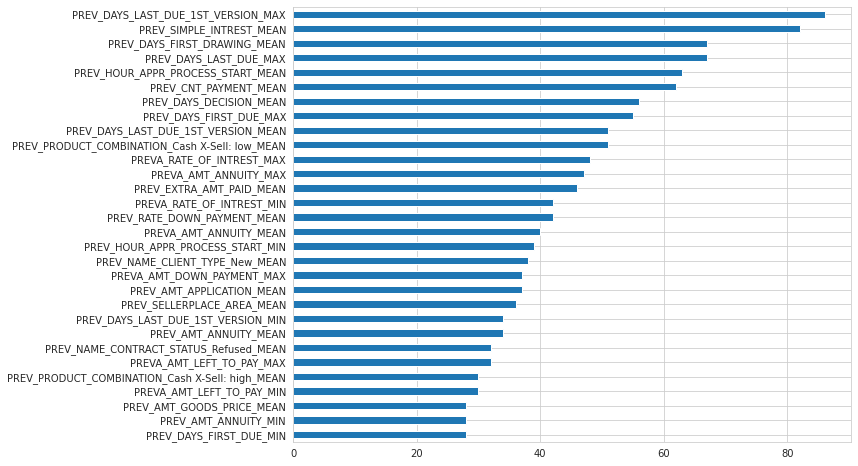

In [ ]:
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

# POS_CASH_balance.csv

### POS_CASH_balance.csv

* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [52]:
pos_data = pd.read_csv('POS_CASH_balance.csv')

In [ ]:
pos_data.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
pos_data['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [53]:
pos_data['PAID_INSTALMENT']=pos_data['CNT_INSTALMENT']-pos_data['CNT_INSTALMENT_FUTURE']

In [54]:
pos_data=pos_data[pos_data['NAME_CONTRACT_STATUS']!='XNA']

In [55]:
#one hotcoding
pos_data,pos_data_cat_columns=one_hot_encoding_dataframe(pos_data)

In [56]:
#Aggregation
pos_data_agg={}
for col in pos_data.columns:
    if col!='SK_ID_CURR' and col !='SK_ID_PREV':
        pos_data_agg[col]=['mean','min','max']

In [57]:
#Apply Aggregation
pos_agg = pos_data.groupby('SK_ID_CURR').agg(pos_data_agg)

In [58]:
pos_agg.head()

MONTHS_BALANCE          ... NAME_CONTRACT_STATUS_Signed        
                     mean min max  ...                        mean min max
SK_ID_CURR                         ...                                    
100001         -72.555556 -96 -53  ...                    0.000000   0   0
100002         -10.000000 -19  -1  ...                    0.000000   0   0
100003         -43.785714 -77 -18  ...                    0.000000   0   0
100004         -25.500000 -27 -24  ...                    0.000000   0   0
100005         -20.000000 -25 -15  ...                    0.090909   0   1

[5 rows x 42 columns]

In [59]:
#modify columns name
modified_col=[]
for c in list(pos_agg.columns):
    modified_col.append("POS_"+c[0]+"_"+c[1].upper())
pos_agg.columns=modified_col

In [60]:
pos_agg.head()

,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_DEF_MIN,POS_SK_DPD_DEF_MAX,POS_PAID_INSTALMENT_MEAN,POS_PAID_INSTALMENT_MIN,POS_PAID_INSTALMENT_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Active_MIN,POS_NAME_CONTRACT_STATUS_Active_MAX,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MIN,POS_NAME_CONTRACT_STATUS_Amortized debt_MAX,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MIN,POS_NAME_CONTRACT_STATUS_Approved_MAX,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MIN,POS_NAME_CONTRACT_STATUS_Canceled_MAX,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MIN,POS_NAME_CONTRACT_STATUS_Completed_MAX,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MIN,POS_NAME_CONTRACT_STATUS_Demand_MAX,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MIN,POS_NAME_CONTRACT_STATUS_Returned to the store_MAX,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MIN,POS_NAME_CONTRACT_STATUS_Signed_MAX
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-72.555556,-96,-53,4.000000,4.0,4.0,1.444444,0.0,4.0,0.777778,0,7,0.777778,0,7,2.555556,0.0,4.0,0.777778,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.222222,0,1,0.0,0,0,0.0,0,0,0.000000,0,0
100002,-10.000000,-19,-1,24.000000,24.0,24.0,15.000000,6.0,24.0,0.000000,0,0,0.000000,0,0,9.000000,0.0,18.0,1.000000,1,1,0.0,0,0,0.0,0,0,0.0,0,0,0.000000,0,0,0.0,0,0,0.0,0,0,0.000000,0,0
100003,-43.785714,-77,-18,10.107143,6.0,12.0,5.785714,0.0,12.0,0.000000,0,0,0.000000,0,0,4.321429,0.0,11.0,0.928571,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.071429,0,1,0.0,0,0,0.0,0,0,0.000000,0,0
100004,-25.500000,-27,-24,3.750000,3.0,4.0,2.250000,0.0,4.0,0.000000,0,0,0.000000,0,0,1.500000,0.0,3.0,0.750000,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.250000,0,1,0.0,0,0,0.0,0,0,0.000000,0,0
100005,-20.000000,-25,-15,11.700000,9.0,12.0,7.200000,0.0,12.0,0.000000,0,0,0.000000,0,0,4.500000,0.0,9.0,0.818182,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.090909,0,1,0.0,0,0,0.0,0,0,0.090909,0,1


In [61]:
pos_agg['ACTVIE_COMP']=pos_agg['POS_NAME_CONTRACT_STATUS_Completed_MEAN']-pos_agg['POS_NAME_CONTRACT_STATUS_Active_MEAN']

#### (app_train,app_test)+POS_CASH_balance.csv using SK_ID_CURR

In [62]:
df_pos = df.join(pos_agg, how='left', on='SK_ID_CURR')

In [ ]:
#Let us look at the coorelation of our newly added feature with the TARGET
df_corr=correlation_with_target_top_n(df_pos[df_pos['TARGET'].notnull()],20)

20 Positive Correlations:
 FLAG_EMP_PHONE                                       0.045980
AMT_CREDIT_DAYS_EMPLOYED_PERC                        0.049296
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049816
REG_CITY_NOT_WORK_CITY                               0.050999
DAYS_ID_PUBLISH                                      0.051463
CODE_GENDER_M                                        0.054719
DAYS_LAST_PHONE_CHANGE                               0.055208
POS_MONTHS_BALANCE_MIN                               0.055319
NAME_INCOME_TYPE_Working                             0.057474
ANNUITY_DAYS_EMPLOYED_PERC                           0.058183
REGION_RATING_CLIENT                                 0.058903
REGION_RATING_CLIENT_W_CITY                          0.060897
GOODS_PRICE_CREDIT_PER                               0.069426
MAX_DAYS_SOMETHING_CHANGED                           0.073441
DAYS_EMPLOYED                                        0.074950
DAYS_BIRTH                                 

### POS_MONTHS_BALANCE_MIN  

* Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )

* Minimum Data of Month available

Text(0.5, 0, 'POS_MONTHS_BALANCE_MIN')

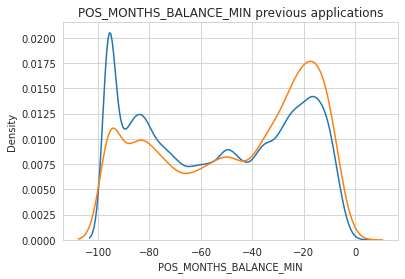

In [63]:
sns.kdeplot(df_pos.loc[df_pos['TARGET']==0,'POS_MONTHS_BALANCE_MIN'],label='target==0')
sns.kdeplot(df_pos.loc[df_pos['TARGET']==1,'POS_MONTHS_BALANCE_MIN'],label='target==1')
plt.title('POS_MONTHS_BALANCE_MIN previous applications')
plt.ylabel('Density')
plt.xlabel('POS_MONTHS_BALANCE_MIN')

#### Analysis

* If the min months are less than -60 then target==0 (can repay the loan)
* If the min months are greater than -40 then target==1 (cannot repay the loan)


#### Conclusion

* The more the snapshots related to the months much before the application date available with Home credit greater probability to repay loan.
* The lesser the snapshots  related to the months much before the application date available with Home credit greater probability of having difficulty in paying loan.



# final feature engineering applied on pos_application

In [5]:
def feature_engineering_on_pos_application():
    
    '''
    final feature engineering applied on pos_application
    
    '''
    pos_data = pd.read_csv('POS_CASH_balance.csv')
    
    pos_data=pos_data[pos_data['NAME_CONTRACT_STATUS']!='XNA'] 
    
    pos_data,pos_data_cat_columns,all_columns=one_hot_encoding_dataframe(pos_data)
    with open("all_columns_pos_data.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    
    
    pos_data_agg={}
    for col in pos_data.columns:
        if col!='SK_ID_CURR' and col !='SK_ID_PREV':
            pos_data_agg[col]=['mean']
        if col=='MONTHS_BALANCE':
            pos_data_agg[col]=['sum','mean','max','min']
            
    
    pos_agg = pos_data.groupby('SK_ID_CURR').agg(pos_data_agg)
    
    modified_col=[]
    for c in list(pos_agg.columns):
        modified_col.append("POS_"+c[0]+"_"+c[1].upper())
    pos_agg.columns=modified_col
    
    pos_agg['COUNT_OF_POS'] = pos_data.groupby('SK_ID_CURR')['SK_ID_PREV'].count() 

    month = -24 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['24_MON_CNT_INSTALMENT_FUTURE_MEAN'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    pos_agg['24_MON_CNT_INSTALMENT_FUTURE_MIN'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].min()
    pos_agg['24_MON_CNT_INSTALMENT_FUTURE_MAX'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
    
    month = -12 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['12_MON_CNT_INSTALMENT_FUTURE_MEAN'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    pos_agg['12_MON_CNT_INSTALMENT_FUTURE_MIN'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].min()
    pos_agg['12_MON_CNT_INSTALMENT_FUTURE_MAX'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
    
    # month = -6 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['6_MON_CNT_INSTALMENT_FUTURE'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    
    
    # month = -3 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['3_MON_CNT_INSTALMENT_FUTURE'] = pos_temp.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    
    
    ########################################3
    
    month = -24 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['24_SK_DPD_MEAN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].mean()
    pos_agg['24_SK_DPD_MIN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].min()
    pos_agg['24_SK_DPD_MAX'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].max()

    month = -12 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['12_SK_DPD_MEAN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].mean()
    pos_agg['12_SK_DPD_MIN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].min()
    pos_agg['12_SK_DPD_MAX'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].max()
    
    # month = -6 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['6_SK_DPD'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].mean()
    
    
    # month = -3 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['3_SK_DPD'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD'].mean()
    
    ###############################
    
    month = -24 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['24_SK_DPD_DEF_MEAN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    # pos_agg['24_SK_DPD_DEF_MIN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].min()
    pos_agg['24_SK_DPD_DEF_MAX'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()

    month = -12 
    pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    pos_agg['12_SK_DPD_DEF_MEAN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    # pos_agg['12_SK_DPD_DEF_MIN'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].min()
    pos_agg['12_SK_DPD_DEF_MAX'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
    
    # month = -6 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['6_SK_DPD_DEF'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    
    
    # month = -3 
    # pos_temp = pos_data[pos_data.MONTHS_BALANCE >= month].copy()
    # pos_agg['3_SK_DPD_DEF'] = pos_temp.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    
    active = pos_data[pos_data['NAME_CONTRACT_STATUS_Active'] == 1]
    pos_agg['POSACT_CNT_INSTALMENT_FUTURE_MEAN'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    pos_agg['POSACT_CNT_INSTALMENT_FUTURE_MIN'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].min()
    pos_agg['POSACT_CNT_INSTALMENT_FUTURE_MAX'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
  
    pos_agg['POSACT_CNT_INSTALMENT_MEAN'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT'].mean()
    pos_agg['POSACT_CNT_INSTALMENT_MIN'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT'].min()
    pos_agg['POSACT_CNT_INSTALMENT_MAX'] = active.groupby('SK_ID_CURR')['CNT_INSTALMENT'].max()
  
    pos_agg['POSACT_SK_DPD_MEAN'] = active.groupby('SK_ID_CURR')['SK_DPD'].mean()
    pos_agg['POSACT_SK_DPD_MIN'] = active.groupby('SK_ID_CURR')['SK_DPD'].min()
    pos_agg['POSACT_SK_DPD_MAX'] = active.groupby('SK_ID_CURR')['SK_DPD'].max()

    pos_agg['POSACT_SK_DPD_DEF_MEAN'] = active.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    pos_agg['POSACT_SK_DPD_DEF_MIN'] = active.groupby('SK_ID_CURR')['SK_DPD_DEF'].min()
    pos_agg['POSACT_SK_DPD_DEF_MAX'] = active.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()
  
    completed = pos_data[pos_data['NAME_CONTRACT_STATUS_Completed'] == 1]

    pos_agg['POSCOMP_CNT_INSTALMENT_FUTURE_MEAN'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].mean()
    pos_agg['POSCOMP_CNT_INSTALMENT_FUTURE_MIN'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].min()
    pos_agg['POSCOMP_CNT_INSTALMENT_FUTURE_MAX'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT_FUTURE'].max()
  
    pos_agg['POSCOMP_CNT_INSTALMENT_MEAN'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT'].mean()
    pos_agg['POSCOMP_CNT_INSTALMENT_MIN'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT'].min()
    pos_agg['POSCOMP_CNT_INSTALMENT_MAX'] = completed.groupby('SK_ID_CURR')['CNT_INSTALMENT'].max()
  
    pos_agg['POSCOMP_SK_DPD_MEAN'] = completed.groupby('SK_ID_CURR')['SK_DPD'].mean()
    pos_agg['POSCOMP_SK_DPD_MIN'] = completed.groupby('SK_ID_CURR')['SK_DPD'].min()
    pos_agg['POSCOMP_SK_DPD_MAX'] = completed.groupby('SK_ID_CURR')['SK_DPD'].max()

    pos_agg['POSCOMP_SK_DPD_DEF_MEAN'] = completed.groupby('SK_ID_CURR')['SK_DPD_DEF'].mean()
    pos_agg['POSCOMP_SK_DPD_DEF_MIN'] = completed.groupby('SK_ID_CURR')['SK_DPD_DEF'].min()
    pos_agg['POSCOMP_SK_DPD_DEF_MAX'] = completed.groupby('SK_ID_CURR')['SK_DPD_DEF'].max()


    del pos_data
    
    gc.collect()
    
    return pos_agg
    

In [ ]:
df_pos=feature_engineering_on_pos_application()
df_pos =df.join(df_pos, how='left', on='SK_ID_CURR')
df_pos=df_pos[df_pos['TARGET'].notnull()]

y_train=df_pos['TARGET']
train_column=set(df_pos.columns)-set(df.columns)
X_train=df_pos[train_column]

train_column=X_train.columns
X_train=X_train.replace([np.inf, -np.inf],np.nan)
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)
scaler = MinMaxScaler(feature_range = (0, 1))
X_train=scaler.fit_transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))

del df_pos,X_train
gc.collect()

ROCAUC Score : 0.6639906368872607


33

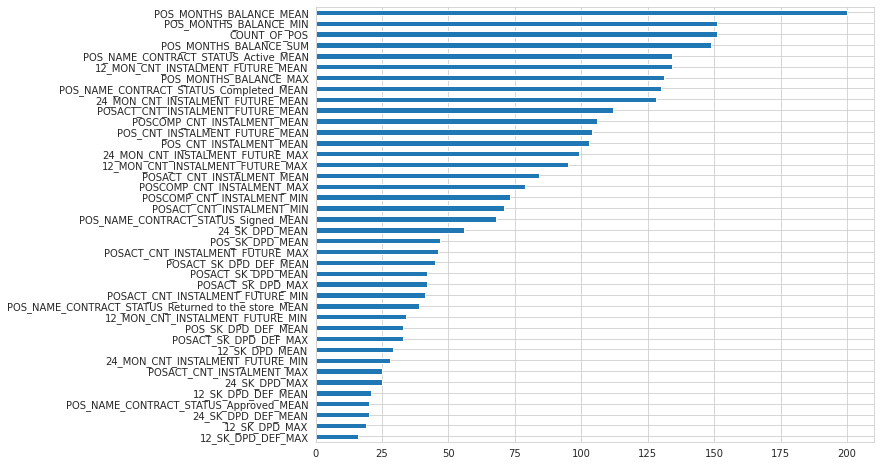

In [ ]:
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(40).sort_values().plot(kind='barh')

# credit_card_balance.csv

### credit_card_balance.csv

* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [38]:
credit_data = pd.read_csv('credit_card_balance.csv')

In [ ]:
credit_data.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [39]:
credit_data['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [40]:
credit_data['FLAG_GRT_30']=(credit_data['AMT_DRAWINGS_CURRENT']>(0.30*credit_data['AMT_CREDIT_LIMIT_ACTUAL'])).astype(int)

In [42]:
credit_data,credit_data_cat_columns=one_hot_encoding_dataframe(credit_data)

In [43]:
credit_data_agg={}
for col in credit_data.columns:
    if col!='SK_ID_CURR' and col !='SK_ID_PREV':
        credit_data_agg[col]=['mean']
        if (col=='FLAG_GRT_30') | (col=='FLAG_GRT_40')| (col=='FLAG_GRT_50') |(col=='FLAG_GRT_60')| (col=='FLAG_GRT_100') :
            credit_data_agg[col]=['sum']

In [44]:
credit_agg = credit_data.groupby('SK_ID_CURR').agg(credit_data_agg)

In [45]:
credit_agg.head()

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,FLAG_GRT_30,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,sum,mean,mean,mean,mean,mean,mean,mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,4520.067568,52402.088919,54433.179122,54433.179122,0.054054,0.054054,0.0,0.0,25.767123,0.000000,0.000000,1,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,6817.172344,17255.559844,18101.079844,18101.079844,0.255556,0.239583,0.0,0.0,18.719101,0.010417,0.010417,4,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [46]:
modified_col=[]
for c in list(credit_agg.columns):
    modified_col.append("CRED_"+c[0]+"_"+c[1].upper())
credit_agg.columns=modified_col

In [47]:
credit_agg.head()

,CRED_MONTHS_BALANCE_MEAN,CRED_AMT_BALANCE_MEAN,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CRED_AMT_DRAWINGS_ATM_CURRENT_MEAN,CRED_AMT_DRAWINGS_CURRENT_MEAN,CRED_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CRED_AMT_DRAWINGS_POS_CURRENT_MEAN,CRED_AMT_INST_MIN_REGULARITY_MEAN,CRED_AMT_PAYMENT_CURRENT_MEAN,CRED_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CRED_AMT_RECEIVABLE_PRINCIPAL_MEAN,CRED_AMT_RECIVABLE_MEAN,CRED_AMT_TOTAL_RECEIVABLE_MEAN,CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN,CRED_CNT_DRAWINGS_CURRENT_MEAN,CRED_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CRED_CNT_DRAWINGS_POS_CURRENT_MEAN,CRED_CNT_INSTALMENT_MATURE_CUM_MEAN,CRED_SK_DPD_MEAN,CRED_SK_DPD_DEF_MEAN,CRED_FLAG_GRT_30_SUM,CRED_NAME_CONTRACT_STATUS_Active_MEAN,CRED_NAME_CONTRACT_STATUS_Approved_MEAN,CRED_NAME_CONTRACT_STATUS_Completed_MEAN,CRED_NAME_CONTRACT_STATUS_Demand_MEAN,CRED_NAME_CONTRACT_STATUS_Refused_MEAN,CRED_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100006,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,4520.067568,52402.088919,54433.179122,54433.179122,0.054054,0.054054,0.0,0.0,25.767123,0.000000,0.000000,1,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,6817.172344,17255.559844,18101.079844,18101.079844,0.255556,0.239583,0.0,0.0,18.719101,0.010417,0.010417,4,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [48]:
month = -3 
cred_temp = credit_data[credit_data.MONTHS_BALANCE >= month].copy()
cred_temp['CRED_UTIL'] = cred_temp['AMT_BALANCE'] / cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
credit_agg['CREDIT_UTIL_MAX'] = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL'].max()

#### (app_train,app_test)+credit_card_balance.csv using SK_ID_CURR

In [49]:
df_credit = df.join(credit_agg, how='left', on='SK_ID_CURR')

In [50]:
#Let us look at the coorelation of our newly added feature with the TARGET
df_corr=correlation_with_target_top_n(df_credit[df_credit['TARGET'].notnull()],20)

20 Positive Correlations:
 NAME_INCOME_TYPE_Working              0.057474
ANNUITY_DAYS_EMPLOYED_PERC            0.058183
CRED_AMT_DRAWINGS_CURRENT_MEAN        0.058732
REGION_RATING_CLIENT                  0.058903
CRED_AMT_DRAWINGS_ATM_CURRENT_MEAN    0.059925
REGION_RATING_CLIENT_W_CITY           0.060897
CRED_MONTHS_BALANCE_MEAN              0.062081
GOODS_PRICE_CREDIT_PER                0.069426
MAX_DAYS_SOMETHING_CHANGED            0.073441
CRED_AMT_INST_MIN_REGULARITY_MEAN     0.073724
DAYS_EMPLOYED                         0.074950
DAYS_BIRTH                            0.078235
CRED_CNT_DRAWINGS_CURRENT_MEAN        0.082520
CRED_AMT_RECEIVABLE_PRINCIPAL_MEAN    0.086062
CRED_AMT_RECIVABLE_MEAN               0.086478
CRED_AMT_TOTAL_RECEIVABLE_MEAN        0.086490
CRED_AMT_BALANCE_MEAN                 0.087177
CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.107692
CREDIT_UTIL_MAX                       0.163077
TARGET                                1.000000
Name: TARGET, dtype: float64

 20

### CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN

* Mean Number of drawings at ATM during months on the previous credit by the client

Text(0.5, 0, 'CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN')

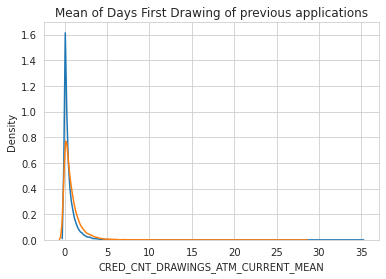

In [51]:
sns.kdeplot(df_credit.loc[df_credit['TARGET']==0,'CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN'],label='target==0')
sns.kdeplot(df_credit.loc[df_credit['TARGET']==1,'CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN'],label='target==1')
plt.title('Mean of Days First Drawing of previous applications')
plt.ylabel('Density')
plt.xlabel('CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN')

#### Analysis

* If the number of drawings is <5 then is more likely to be a client who cannot repay the loan.
* If the number of drawings is >28 then is more likely to be a client who can repay the loan.



#### Conclusion

* CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN is a very useful feature

# final feature engineering applied on credit_card_balance

In [4]:
def feature_engineering_on_credit_card_balance():
    
    '''
    final feature engineering applied on credit_card_balance
    
    '''
    credit_data = pd.read_csv('credit_card_balance.csv')
    
    credit_data['FLAG_LESS_30']=(credit_data['AMT_DRAWINGS_CURRENT']<(0.30*credit_data['AMT_CREDIT_LIMIT_ACTUAL'])).astype(int)
    credit_data['FLAG_LESS_60']=(credit_data['AMT_DRAWINGS_CURRENT']<(0.60*credit_data['AMT_CREDIT_LIMIT_ACTUAL'])).astype(int)
    credit_data['FLAG_LESS_90']=(credit_data['AMT_DRAWINGS_CURRENT']<(0.90*credit_data['AMT_CREDIT_LIMIT_ACTUAL'])).astype(int)
#     credit_data['FLAG_GRT_30']=(credit_data['AMT_DRAWINGS_CURRENT']>(0.30*credit_data['AMT_CREDIT_LIMIT_ACTUAL'])).astype(int)
    
    credit_data,credit_data_cat_columns,all_columns=one_hot_encoding_dataframe(credit_data)
    with open("all_columns_credit_data.pkl", "wb") as f:
        pkl.dump(all_columns, f)
    
    credit_data_agg={}
    for col in credit_data.columns:
        if col!='SK_ID_CURR' and col !='SK_ID_PREV':
            credit_data_agg[col]=['mean']
            if (col=='FLAG_GRT_30')|(col=='NAME_CONTRACT_STATUS') :
                credit_data_agg[col]=['sum']
            if col=='MONTH_BALANCE':
                credit_data_agg[col]=['min','mean']
                
    
    credit_agg = credit_data.groupby('SK_ID_CURR').agg(credit_data_agg)
    
    modified_col=[]
    for c in list(credit_agg.columns):
        modified_col.append("CRED_"+c[0]+"_"+c[1].upper())
    credit_agg.columns=modified_col
    
    month = -3 
    cred_temp = credit_data[credit_data.MONTHS_BALANCE >= month].copy()
    cred_temp['CRED_UTIL_PER'] = (cred_temp['AMT_BALANCE'])/ cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
    credit_agg['3_CREDIT_UTIL_PER_MEAN'] = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL_PER'].mean()
    
    month = -6 
    cred_temp = credit_data[credit_data.MONTHS_BALANCE >= month].copy()
    cred_temp['CRED_UTIL_PER'] = (cred_temp['AMT_BALANCE'])/ cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
    credit_agg['6_CREDIT_UTIL_PER_MEAN'] = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL_PER'].mean()
    
    month = -12 
    cred_temp = credit_data[credit_data.MONTHS_BALANCE >= month].copy()
    cred_temp['CRED_UTIL_PER'] = (cred_temp['AMT_BALANCE'])/ cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
    credit_agg['12_CREDIT_UTIL_PER_MEAN'] = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL_PER'].mean()
    
    month = -24 
    cred_temp = credit_data[credit_data.MONTHS_BALANCE >= month].copy()
    cred_temp['CRED_UTIL_PER'] = (cred_temp['AMT_BALANCE'])/ cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
    credit_agg['24_CREDIT_UTIL_PER_MEAN'] = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL_PER'].mean()
    
    
    credit_agg['COUNT_OF_CREDITS'] = credit_data.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
  
     
    del credit_data
    
    gc.collect()
    
    
    return credit_agg
    

In [ ]:
df_credit=feature_engineering_on_credit_card_balance()
df_credit =df.join(df_credit, how='left', on='SK_ID_CURR')
df_credit=df_credit[df_credit['TARGET'].notnull()]

y_train=df_credit['TARGET']
train_column=set(df_credit.columns)-set(df.columns)
X_train=df_credit[train_column]

train_column=X_train.columns
X_train=X_train.replace([np.inf, -np.inf],np.nan)
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)
scaler = MinMaxScaler(feature_range = (0, 1))
X_train=scaler.fit_transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))

del df_credit,X_train
gc.collect()

ROCAUC Score : 0.6104911421085034


33

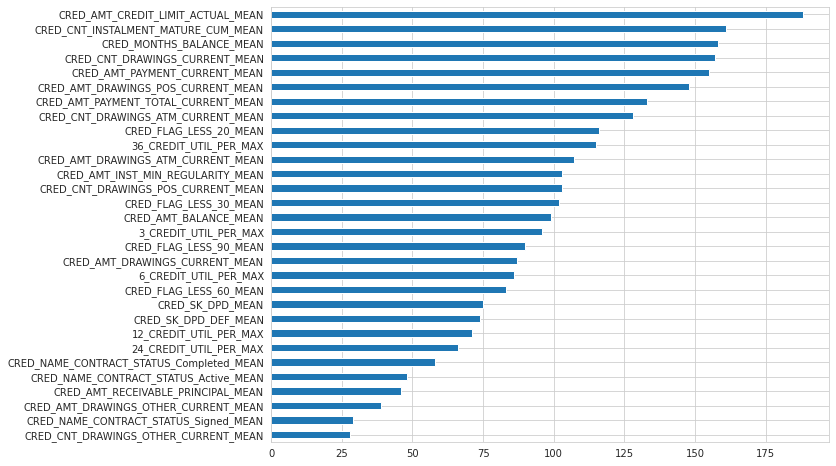

In [ ]:
plt.figure(figsize=(10,8))
feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

# installments_payments.csv

### installments_payments.csv
* Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
* There is a) one row for every payment that was made plus b) one row each for missed payment.
* One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [22]:
installments_payments_data = pd.read_csv('installments_payments.csv')

In [23]:
installments_payments_data.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [24]:
installments_payments_data['NUM_INSTALMENT_VERSION'].value_counts()

1.0      8485004
0.0      4082498
2.0       620283
3.0       237063
4.0        55274
          ...   
58.0           1
59.0           1
178.0          1
68.0           1
73.0           1
Name: NUM_INSTALMENT_VERSION, Length: 65, dtype: int64

In [25]:
installments_payments_data['LATE_PAYMENT']=((installments_payments_data['DAYS_INSTALMENT']-installments_payments_data['DAYS_ENTRY_PAYMENT'])>0).astype(int)
installments_payments_data['LESS_PAYMENT']=((installments_payments_data['AMT_INSTALMENT']-installments_payments_data['AMT_PAYMENT'])>0).astype(int)

In [26]:
installments_payments_data.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,LATE_PAYMENT,LESS_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,1,0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,0,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,0,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,1,0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,0,1


In [27]:
for col in installments_payments_data.columns:
    if col.startswith('DAYS'):
        installments_payments_data[col].replace(365243, np.nan, inplace= True)

In [28]:
installments_payments_data,installments_payments_cat_columns=one_hot_encoding_dataframe(installments_payments_data)

In [29]:
installments_payments_data_agg={}
for col in installments_payments_data.columns:
    if col!='SK_ID_CURR' and col !='SK_ID_PREV':
        installments_payments_data_agg[col]=['mean']
        if (col=='LATE_PAYMENT') |  (col=='LESS_PAYMENT'):
            installments_payments_data_agg[col]=['sum']

In [30]:
installments_payments_agg = installments_payments_data.groupby('SK_ID_CURR').agg(installments_payments_data_agg)

In [31]:
installments_payments_agg.head()

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,LATE_PAYMENT,LESS_PAYMENT
,mean,mean,mean,mean,mean,mean,sum,sum
SK_ID_CURR,,,,,,,,
100001,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,4,0
100002,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,19,0
100003,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,25,0
100004,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,0
100005,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,8,0


In [32]:
modified_col=[]
for c in list(installments_payments_agg.columns):
    modified_col.append("INST_"+c[0]+"_"+c[1].upper())
installments_payments_agg.columns=modified_col

In [33]:
installment_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= -365].copy()
installment_temp['LATE_PAYMENT'] = installment_temp['DAYS_INSTALMENT']-installment_temp['DAYS_ENTRY_PAYMENT']
installments_payments_agg['MIN_LATE_PAYMENT_365'] = installment_temp.groupby('SK_ID_CURR')[['LATE_PAYMENT']].min()

In [34]:
# allment_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= -365].copy()
installment_temp['LESS_PAYMENT'] =installment_temp['AMT_INSTALMENT']-installment_temp['AMT_PAYMENT']
installments_payments_agg['COUNT_LESS_PAYMENT_365'] = installment_temp.groupby('SK_ID_CURR')[['LESS_PAYMENT']].count()

In [35]:
installments_payments_agg.head()

,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_NUMBER_MEAN,INST_DAYS_INSTALMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_AMT_INSTALMENT_MEAN,INST_AMT_PAYMENT_MEAN,INST_LATE_PAYMENT_SUM,INST_LESS_PAYMENT_SUM,MIN_LATE_PAYMENT_365,COUNT_LESS_PAYMENT_365
SK_ID_CURR,,,,,,,,,,
100001,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,4,0,NaN,NaN
100002,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,19,0,12.0,11.0
100003,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,25,0,NaN,NaN
100004,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,0,NaN,NaN
100005,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,8,0,NaN,NaN


#### (app_train,app_test)+installments_payments.csv using SK_ID_CURR

In [36]:
df_installments_payments = df.join(installments_payments_agg, how='left', on='SK_ID_CURR')

In [37]:
#Let us look at the coorelation of our newly added feature with the TARGET
df_corr=correlation_with_target_top_n(df_installments_payments[df_installments_payments['TARGET'].notnull()],20)

20 Positive Correlations:
 INST_DAYS_ENTRY_PAYMENT_MEAN                         0.044005
FLAG_DOCUMENT_3                                      0.044335
REG_CITY_NOT_LIVE_CITY                               0.044398
ADDRESS_MISSMATCH                                    0.044845
FLAG_EMP_PHONE                                       0.045980
AMT_CREDIT_DAYS_EMPLOYED_PERC                        0.049296
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049816
REG_CITY_NOT_WORK_CITY                               0.050999
DAYS_ID_PUBLISH                                      0.051463
CODE_GENDER_M                                        0.054719
DAYS_LAST_PHONE_CHANGE                               0.055208
NAME_INCOME_TYPE_Working                             0.057474
ANNUITY_DAYS_EMPLOYED_PERC                           0.058183
REGION_RATING_CLIENT                                 0.058903
REGION_RATING_CLIENT_W_CITY                          0.060897
GOODS_PRICE_CREDIT_PER                     

# final feature engineering applied on installments_payments_balance

In [3]:
def feature_engineering_on_installments_payments_balance():
    
    '''
    final feature engineering applied on installments_payments_balance
    
    '''
    installments_payments_data = pd.read_csv('installments_payments.csv')
    
    
    installments_payments_data['LATE_PAYMENT']=installments_payments_data['DAYS_INSTALMENT']-installments_payments_data['DAYS_ENTRY_PAYMENT']
    
    installments_payments_data['LESS_PAYMENT']=installments_payments_data['AMT_INSTALMENT']-installments_payments_data['AMT_PAYMENT']
    
    installments_payments_data['LATE_LESS_PAYMENT']=0.5*installments_payments_data['LATE_PAYMENT']+0.5*installments_payments_data['LESS_PAYMENT']
    
    installments_payments_data['LATE_PAYMENT_FLAG']=((installments_payments_data['DAYS_INSTALMENT']-installments_payments_data['DAYS_ENTRY_PAYMENT'])>0).astype(int)
    
    installments_payments_data['LESS_PAYMENT_FLAG']=((installments_payments_data['AMT_INSTALMENT']-installments_payments_data['AMT_PAYMENT'])>0).astype(int)
    
    for col in installments_payments_data.columns:
        if col.startswith('DAYS'):
            installments_payments_data[col].replace(365243, np.nan, inplace= True)
            
    installments_payments_data,installments_payments_cat_columns,all_columns=one_hot_encoding_dataframe(installments_payments_data)
    with open("all_columns_installments_payments_data.pkl", "wb") as f:
        pkl.dump(all_columns, f)    

    installments_payments_data_agg={}
    for col in installments_payments_data.columns:
        if col!='SK_ID_CURR' and col !='SK_ID_PREV':
            installments_payments_data_agg[col]=['mean']
            if (col=='LATE_PAYMENT') |  (col=='LESS_PAYMENT') | (col=='NUM_INSTALMENT_VERSION') | (col=='NUM_INSTALMENT_NUMBER'):
              installments_payments_data_agg[col]=['mean','sum','max','min']
    
    installments_payments_agg = installments_payments_data.groupby('SK_ID_CURR').agg(installments_payments_data_agg)
    
    modified_col=[]
    for c in list(installments_payments_agg.columns):
        modified_col.append("INST_"+c[0]+"_"+c[1].upper())
    installments_payments_agg.columns=modified_col
    
    
    installments_payments_agg['COUNT_OF_INST'] = installments_payments_data.groupby('SK_ID_CURR')['SK_ID_PREV'].count()


    no = -365*3
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    installments_payments_agg['3365_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['3365_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['3365_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    installments_payments_agg['3365_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum() 

    
    no = -365*2
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    installments_payments_agg['2365_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['2365_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['2365_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    installments_payments_agg['2365_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum()
    

    no = -365 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    installments_payments_agg['365_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['365_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['365_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    installments_payments_agg['365_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum()
    
    no = -180 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['180_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['180_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['180_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    installments_payments_agg['180_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum()
    
    no = -90 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['90_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['90_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['90_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    # installments_payments_agg['90_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum()
    
    no = -30 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['30_LATE_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].mean()
    installments_payments_agg['30_LATE_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].min()
    installments_payments_agg['30_LATE_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT'].max()
    # installments_payments_agg['30_LATE_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LATE_PAYMENT_FLAG'].sum()

    
    ###############################################################################################
    # no = -365*3
    # installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    # installments_payments_agg['3365_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    # installments_payments_agg['3365_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    # installments_payments_agg['3365_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    # installments_payments_agg['3365_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()
    
    
    no = -365*2
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    installments_payments_agg['2365_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    installments_payments_agg['2365_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    installments_payments_agg['2365_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    installments_payments_agg['2365_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()

    no = -365 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >=no].copy()
    installments_payments_agg['365_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    installments_payments_agg['365_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    installments_payments_agg['365_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    installments_payments_agg['365_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()
    
    no = -180 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['180_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    installments_payments_agg['180_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    installments_payments_agg['180_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    # installments_payments_agg['180_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()
    
    no = -90 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['90_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    installments_payments_agg['90_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    installments_payments_agg['90_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    # installments_payments_agg['90_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()
    
    no = -30 
    installments_payments_agg_temp = installments_payments_data[installments_payments_data.DAYS_ENTRY_PAYMENT >= no].copy()
    installments_payments_agg['30_LESS_PAYMENT_FLAG_MEAN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].mean()
    installments_payments_agg['30_LESS_PAYMENT_FLAG_MIN'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].min()
    installments_payments_agg['30_LESS_PAYMENT_FLAG_MAX'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT'].max()
    # installments_payments_agg['30_LESS_PAYMENT_FLAG_COUNT'] = installments_payments_agg_temp.groupby('SK_ID_CURR')['LESS_PAYMENT_FLAG'].sum()
    
    
    del installments_payments_data,installments_payments_agg_temp
    
    gc.collect()
    
    
    return installments_payments_agg

In [ ]:
df_installments_payments=feature_engineering_on_installments_payments_balance()
df_installments_payments =df.join(df_installments_payments, how='left', on='SK_ID_CURR')
df_installments_payments=df_installments_payments[df_installments_payments['TARGET'].notnull()]

y_train=df_installments_payments['TARGET']
train_column=set(df_installments_payments.columns)-set(df.columns)
X_train=df_installments_payments[train_column]

train_column=X_train.columns
X_train=X_train.replace([np.inf, -np.inf],np.nan)
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')
X_train=imputer1.fit_transform(X_train)
scaler = MinMaxScaler(feature_range = (0, 1))
X_train=scaler.fit_transform(X_train)

lgbm_clf = LGBMClassifier(nthread = -1,random_state=42)
lgbm_clf.fit(X_train,y_train)

print("ROCAUC Score :",roc_auc_score(y_train,lgbm_clf.predict_proba(X_train)[:,1]))

del df_installments_payments,X_train
gc.collect()

ROCAUC Score : 0.7007513894128544


33

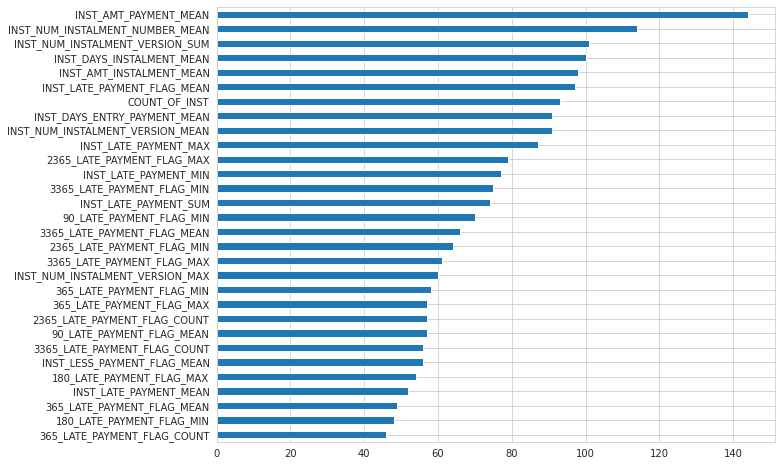

In [ ]:
plt.figure(figsize=(10,8))
# feat_importances = pd.Series(lgbm_clf.feature_importances_, index=train_column)
feat_importances.nlargest(30).sort_values().plot(kind='barh')

# Final Features 

### (application_{train|test}.csv ) + bureau.csv + bureau_balance.csv + POS_CASH_balance.csv + credit_card_balance.csv + previous_application.csv + credit_card_balance.csv)

In [12]:
df=feature_engineering_on_app_train_test()

df_bureau_agg=feature_engineering_on_bureau_data_balance()
df=df.join(df_bureau_agg,how='left', on='SK_ID_CURR')
del df_bureau_agg
gc.collect()


df_prev_agg=feature_engineering_on_previous_application()
df=df.join(df_prev_agg,how='left', on='SK_ID_CURR')
del df_prev_agg
gc.collect()

df_pos_agg=feature_engineering_on_pos_application()
df=df.join(df_pos_agg,how='left', on='SK_ID_CURR')
del df_pos_agg
gc.collect()

df_credit_agg=feature_engineering_on_credit_card_balance()
df=df.join(df_credit_agg,how='left', on='SK_ID_CURR')
del df_credit_agg
gc.collect()

df_payments_agg=feature_engineering_on_installments_payments_balance()
df=df.join(df_payments_agg,how='left', on='SK_ID_CURR')
del df_payments_agg
gc.collect()

0

Train Data

In [13]:
train_data=df[df['TARGET'].notnull()]

Test Data

In [14]:
test_data=df[df['TARGET'].isnull()]

## Handling missing values

In [16]:
missing_values_data=missing_values(train_data)

Dataframe has 753 columns.
There are 562 columns that have missing values.


### Greater than 75%  Missing Values Columns Deleted

In [17]:
missing_3=missing_values_data[(missing_values_data['% of Total Values']>75)]

In [18]:
len(list(missing_3.index))

22

In [19]:
train_data=train_data.drop(columns=list(missing_3.index)).copy()

In [20]:
test_data=test_data.drop(columns=list(missing_3.index)).copy()

In [21]:
train_data.shape

(307506, 731)

In [22]:
test_data.shape

(48744, 731)

In [23]:
train_data.replace([np.inf, -np.inf], np.nan,inplace=True)

In [24]:
test_data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Less than 30% Missing Values median imputation

In [25]:
miss_data1=missing_values_data[missing_values_data['% of Total Values']<=30]
miss_data1

,Missing Values,% of Total Values
365_LATE_PAYMENT_FLAG_COUNT,91638,29.8
365_LATE_PAYMENT_FLAG_MIN,91638,29.8
365_LATE_PAYMENT_FLAG_MAX,91638,29.8
365_LATE_PAYMENT_FLAG_MEAN,91638,29.8
365_LESS_PAYMENT_FLAG_MIN,91638,29.8
...,...,...
PAY_TOWARDS_LOAN,12,0.0
AMT_ANNUITY,12,0.0
INCOME_PER_PERSON,2,0.0
CNT_FAM_MEMBERS,2,0.0


In [26]:
from sklearn.impute import SimpleImputer
imputer1 = SimpleImputer(missing_values=np.nan, strategy='median')

In [27]:
train_data[list(miss_data1.index)].head()

,365_LATE_PAYMENT_FLAG_COUNT,365_LATE_PAYMENT_FLAG_MIN,365_LATE_PAYMENT_FLAG_MAX,365_LATE_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MIN,365_LESS_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MAX,365_LESS_PAYMENT_FLAG_COUNT,B_ACT_AMT_CREDIT_SUM_MEAN,B_ACT_AMT_CREDIT_SUME_MIN,B_ACT_AMT_CREDIT_SUM_MAX,B_ACT_CREDIT_DAY_OVERDUE_MIN,B_ACT_CREDIT_DAY_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MIN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MAX,B_ACT_CREDIT_DAY_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MEAN,B_ACT_DAYS_CREDIT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MEAN,B_CLO_AMT_CREDIT_SUM_DEBT_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MIN,B_CLO_DAYS_CREDIT_ENDDATE_MEAN,B_CLO_DAYS_ENDDATE_FACT_MEAN,B_CLO_DAYS_ENDDATE_FACT_MIN,B_CLO_DAYS_ENDDATE_FACT_MAX,B_CLO_CREDIT_DAY_OVERDUE_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MAX,B_CLO_AMT_CREDIT_SUM_MEAN,B_CLO_AMT_CREDIT_SUM_MIN,B_CLO_AMT_CREDIT_SUM_MAX,B_CLO_AMT_CREDIT_SUM_OVERDUE_MEAN,B_CLO_DAYS_CREDIT_MAX,B_CLO_DAYS_CREDIT_MIN,B_CLO_DAYS_CREDIT_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MIN,B_CLO_CREDIT_DAY_OVERDUE_MAX,...,INST_LESS_PAYMENT_MAX,INST_LESS_PAYMENT_MIN,INST_LATE_LESS_PAYMENT_MEAN,INST_LATE_PAYMENT_MAX,INST_NUM_INSTALMENT_NUMBER_MEAN,COUNT_OF_INST,INST_NUM_INSTALMENT_NUMBER_MAX,INST_LESS_PAYMENT_FLAG_MEAN,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_VERSION_SUM,INST_NUM_INSTALMENT_VERSION_MIN,INST_NUM_INSTALMENT_NUMBER_SUM,INST_NUM_INSTALMENT_VERSION_MAX,INST_NUM_INSTALMENT_NUMBER_MIN,INST_DAYS_INSTALMENT_MEAN,INST_AMT_INSTALMENT_MEAN,INST_LATE_PAYMENT_SUM,INST_LESS_PAYMENT_SUM,INST_LATE_PAYMENT_FLAG_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,GOODS_PRICE_AMT_ANNUITY_PER,AMT_GOODS_PRICE,GOODS_PRICE_INCOME_TOTAL_PER,GOODS_PRICE_CREDIT_PER,EXT_SOURCE_MEDIAN,EXT_SOURCE_MEAN,EXT_SOURCE_MIN,EXT_SOURCE_MAX,ANNUITY_DAYS_BIRTH_PERC,PAYMENT_RATE,PAYMENT_RATE_INV,PAY_TOWARDS_LOAN,AMT_ANNUITY,INCOME_PER_PERSON,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
0,11.0,12.0,24.0,17.363636,0.0,0.0,0.0,0.0,240994.2825,31988.565,450000.0,0.0,0.0,0.0,0.0,0.0,-103.0,0.0,-572.5,-1042.0,0.0,0.0,0.0,85.0,-1072.0,-574.800000,-697.500000,-1185.0,-36.0,0.0,0.0,63844.5,0.0,135000.0,0.0,-476.0,-1437.0,-974.500000,0.0,0.0,...,0.000,0.0,10.210526,31.0,10.000000,19.0,19.0,0.000000,1.052632,20.0,1.0,190.0,2.0,1.0,-295.000000,11559.247105,388.0,0.000,1.000000,2.0,2.0,2.0,2.0,0.262949,0.070372,351000.0,0.576923,1.158397,0.139376,0.161787,0.083037,0.262949,-0.383029,0.060749,16.461104,177799.5,24700.5,101250.0,1.0,-1134.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810000.0000,810000.000,810000.0,0.0,0.0,0.0,0.0,0.0,-606.0,0.0,-606.0,-606.0,0.0,0.0,0.0,-420.0,-2434.0,-1131.333333,-1097.333333,-2131.0,-540.0,0.0,0.0,69133.5,22248.0,112500.0,0.0,-775.0,-2586.0,-1665.666667,0.0,0.0,...,0.000,0.0,3.580000,14.0,5.080000,25.0,12.0,0.000000,1.040000,26.0,1.0,127.0,2.0,1.0,-1378.160000,64754.586000,179.0,0.000,1.000000,1.0,0.0,1.0,0.0,0.622246,0.031606,1129500.0,0.239044,1.145199,0.466757,0.466757,0.311267,0.622246,-0.469628,0.027598,36.234085,234301.5,35698.5,90000.0,2.0,-828.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-382.0,-595.0,-488.500000,-532.500000,-683.0,-382.0,0.0,0.0,94518.9,94500.0,94537.8,0.0,-408.0,-1326.0,-867.000000,0.0,0.0,...,0.000,0.0,3.833333,11.0,2.000000,3.0,3.0,0.000000,1.333333,4.0,1.0,6.0,2.0,1.0,-754.000000,7096.155000,23.0,0.000,1.000000,0.0,0.0,0.0,0.0,0.555912,0.050000,135000.0,0.500000,1.000000,0.642739,0.642739,0.555912,0.729567,-2.821630,0.050000,20.000000,60750.0,6750.0,33750.0,1.0,-815.0
3,11.0,1.0,23.0,6.181818,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,9.687500,77.0,4.437500,16.0,10.0,0.000000,1.125000,18.0,1.0,71.0,2.0,1.0,-252.250000,62947.088438,310.0,0.000,1.000000,2.0,0.0,2.0,0.0,0.650442,0.099955,297000.0,0.45

In [28]:
imputer1.fit(train_data[list(miss_data1.index)])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [29]:
mean_imp_train_data = imputer1.transform(train_data[list(miss_data1.index)])

In [30]:
mean_imp_test_data  = imputer1.transform(test_data[list(miss_data1.index)])

In [31]:
miss_data1_col=list(miss_data1.index)

In [32]:
train_data.loc[:,miss_data1_col]=mean_imp_train_data.copy()

In [33]:
test_data.loc[:,miss_data1_col]=mean_imp_test_data.copy()

In [ ]:
del mean_imp_train_data,mean_imp_test_data
gc.collect()

40

In [34]:
train_data[list(miss_data1.index)].head()

,365_LATE_PAYMENT_FLAG_COUNT,365_LATE_PAYMENT_FLAG_MIN,365_LATE_PAYMENT_FLAG_MAX,365_LATE_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MIN,365_LESS_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MAX,365_LESS_PAYMENT_FLAG_COUNT,B_ACT_AMT_CREDIT_SUM_MEAN,B_ACT_AMT_CREDIT_SUME_MIN,B_ACT_AMT_CREDIT_SUM_MAX,B_ACT_CREDIT_DAY_OVERDUE_MIN,B_ACT_CREDIT_DAY_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MIN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MAX,B_ACT_CREDIT_DAY_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MEAN,B_ACT_DAYS_CREDIT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MEAN,B_CLO_AMT_CREDIT_SUM_DEBT_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MIN,B_CLO_DAYS_CREDIT_ENDDATE_MEAN,B_CLO_DAYS_ENDDATE_FACT_MEAN,B_CLO_DAYS_ENDDATE_FACT_MIN,B_CLO_DAYS_ENDDATE_FACT_MAX,B_CLO_CREDIT_DAY_OVERDUE_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MAX,B_CLO_AMT_CREDIT_SUM_MEAN,B_CLO_AMT_CREDIT_SUM_MIN,B_CLO_AMT_CREDIT_SUM_MAX,B_CLO_AMT_CREDIT_SUM_OVERDUE_MEAN,B_CLO_DAYS_CREDIT_MAX,B_CLO_DAYS_CREDIT_MIN,B_CLO_DAYS_CREDIT_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MIN,B_CLO_CREDIT_DAY_OVERDUE_MAX,...,INST_LESS_PAYMENT_MAX,INST_LESS_PAYMENT_MIN,INST_LATE_LESS_PAYMENT_MEAN,INST_LATE_PAYMENT_MAX,INST_NUM_INSTALMENT_NUMBER_MEAN,COUNT_OF_INST,INST_NUM_INSTALMENT_NUMBER_MAX,INST_LESS_PAYMENT_FLAG_MEAN,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_VERSION_SUM,INST_NUM_INSTALMENT_VERSION_MIN,INST_NUM_INSTALMENT_NUMBER_SUM,INST_NUM_INSTALMENT_VERSION_MAX,INST_NUM_INSTALMENT_NUMBER_MIN,INST_DAYS_INSTALMENT_MEAN,INST_AMT_INSTALMENT_MEAN,INST_LATE_PAYMENT_SUM,INST_LESS_PAYMENT_SUM,INST_LATE_PAYMENT_FLAG_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,GOODS_PRICE_AMT_ANNUITY_PER,AMT_GOODS_PRICE,GOODS_PRICE_INCOME_TOTAL_PER,GOODS_PRICE_CREDIT_PER,EXT_SOURCE_MEDIAN,EXT_SOURCE_MEAN,EXT_SOURCE_MIN,EXT_SOURCE_MAX,ANNUITY_DAYS_BIRTH_PERC,PAYMENT_RATE,PAYMENT_RATE_INV,PAY_TOWARDS_LOAN,AMT_ANNUITY,INCOME_PER_PERSON,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
0,11.0,12.0,24.0,17.363636,0.0,0.0,0.0,0.0,240994.2825,31988.565,450000.0,0.0,0.0,0.0,0.0,0.0,-103.0,0.0,-572.500000,-1042.0,0.0,0.0,0.0,85.0,-1072.0,-574.800000,-697.500000,-1185.0,-36.0,0.0,0.0,63844.5,0.0,135000.0,0.0,-476.0,-1437.0,-974.500000,0.0,0.0,...,0.000,0.0,10.210526,31.0,10.000000,19.0,19.0,0.000000,1.052632,20.0,1.0,190.0,2.0,1.0,-295.000000,11559.247105,388.0,0.000,1.000000,2.0,2.0,2.0,2.0,0.262949,0.070372,351000.0,0.576923,1.158397,0.139376,0.161787,0.083037,0.262949,-0.383029,0.060749,16.461104,177799.5,24700.5,101250.0,1.0,-1134.0
1,8.0,0.0,21.0,8.200000,0.0,0.0,0.0,0.0,810000.0000,810000.000,810000.0,0.0,0.0,0.0,0.0,0.0,-606.0,0.0,-606.000000,-606.0,0.0,0.0,0.0,-420.0,-2434.0,-1131.333333,-1097.333333,-2131.0,-540.0,0.0,0.0,69133.5,22248.0,112500.0,0.0,-775.0,-2586.0,-1665.666667,0.0,0.0,...,0.000,0.0,3.580000,14.0,5.080000,25.0,12.0,0.000000,1.040000,26.0,1.0,127.0,2.0,1.0,-1378.160000,64754.586000,179.0,0.000,1.000000,1.0,0.0,1.0,0.0,0.622246,0.031606,1129500.0,0.239044,1.145199,0.466757,0.466757,0.311267,0.622246,-0.469628,0.027598,36.234085,234301.5,35698.5,90000.0,2.0,-828.0
2,8.0,0.0,21.0,8.200000,0.0,0.0,0.0,0.0,274500.0000,109768.860,450000.0,0.0,0.0,0.0,0.0,0.0,-258.0,0.0,-537.333333,-764.0,0.0,0.0,0.0,-382.0,-595.0,-488.500000,-532.500000,-683.0,-382.0,0.0,0.0,94518.9,94500.0,94537.8,0.0,-408.0,-1326.0,-867.000000,0.0,0.0,...,0.000,0.0,3.833333,11.0,2.000000,3.0,3.0,0.000000,1.333333,4.0,1.0,6.0,2.0,1.0,-754.000000,7096.155000,23.0,0.000,1.000000,0.0,0.0,0.0,0.0,0.555912,0.050000,135000.0,0.500000,1.000000,0.642739,0.642739,0.555912,0.729567,-2.821630,0.050000,20.000000,60750.0,6750.0,33750.0,1.0,-815.0
3,11.0,1.0,23.0,6.181818,0.0,0.0,0.0,0.0,274500.0000,109768.860,450000.0,0.0,0.0,0.0,0.0,0.0,-258.0,0.0,-537.333333,-764.0,0.0,0.0,0.0,-211.0,-1434.0,-781.000000,-928.800000,-1451.0,-347.0,0.0,0.0,125100.0,42840.0,225000.0,0.0,-729.0,-2002.0,-1366.563492,0.0,0.0,...,0.000,0.0,9.687500,77.0,4.

In [35]:
test_data[list(miss_data1.index)].head()

,365_LATE_PAYMENT_FLAG_COUNT,365_LATE_PAYMENT_FLAG_MIN,365_LATE_PAYMENT_FLAG_MAX,365_LATE_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MIN,365_LESS_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MAX,365_LESS_PAYMENT_FLAG_COUNT,B_ACT_AMT_CREDIT_SUM_MEAN,B_ACT_AMT_CREDIT_SUME_MIN,B_ACT_AMT_CREDIT_SUM_MAX,B_ACT_CREDIT_DAY_OVERDUE_MIN,B_ACT_CREDIT_DAY_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MIN,B_ACT_AMT_CREDIT_SUM_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MAX,B_ACT_CREDIT_DAY_OVERDUE_MAX,B_ACT_DAYS_CREDIT_MEAN,B_ACT_DAYS_CREDIT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MIN,B_CLO_AMT_CREDIT_SUM_DEBT_MEAN,B_CLO_AMT_CREDIT_SUM_DEBT_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MAX,B_CLO_DAYS_CREDIT_ENDDATE_MIN,B_CLO_DAYS_CREDIT_ENDDATE_MEAN,B_CLO_DAYS_ENDDATE_FACT_MEAN,B_CLO_DAYS_ENDDATE_FACT_MIN,B_CLO_DAYS_ENDDATE_FACT_MAX,B_CLO_CREDIT_DAY_OVERDUE_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MAX,B_CLO_AMT_CREDIT_SUM_MEAN,B_CLO_AMT_CREDIT_SUM_MIN,B_CLO_AMT_CREDIT_SUM_MAX,B_CLO_AMT_CREDIT_SUM_OVERDUE_MEAN,B_CLO_DAYS_CREDIT_MAX,B_CLO_DAYS_CREDIT_MIN,B_CLO_DAYS_CREDIT_MEAN,B_CLO_AMT_CREDIT_SUM_OVERDUE_MIN,B_CLO_CREDIT_DAY_OVERDUE_MAX,...,INST_LESS_PAYMENT_MAX,INST_LESS_PAYMENT_MIN,INST_LATE_LESS_PAYMENT_MEAN,INST_LATE_PAYMENT_MAX,INST_NUM_INSTALMENT_NUMBER_MEAN,COUNT_OF_INST,INST_NUM_INSTALMENT_NUMBER_MAX,INST_LESS_PAYMENT_FLAG_MEAN,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_VERSION_SUM,INST_NUM_INSTALMENT_VERSION_MIN,INST_NUM_INSTALMENT_NUMBER_SUM,INST_NUM_INSTALMENT_VERSION_MAX,INST_NUM_INSTALMENT_NUMBER_MIN,INST_DAYS_INSTALMENT_MEAN,INST_AMT_INSTALMENT_MEAN,INST_LATE_PAYMENT_SUM,INST_LESS_PAYMENT_SUM,INST_LATE_PAYMENT_FLAG_MEAN,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,GOODS_PRICE_AMT_ANNUITY_PER,AMT_GOODS_PRICE,GOODS_PRICE_INCOME_TOTAL_PER,GOODS_PRICE_CREDIT_PER,EXT_SOURCE_MEDIAN,EXT_SOURCE_MEAN,EXT_SOURCE_MIN,EXT_SOURCE_MAX,ANNUITY_DAYS_BIRTH_PERC,PAYMENT_RATE,PAYMENT_RATE_INV,PAY_TOWARDS_LOAN,AMT_ANNUITY,INCOME_PER_PERSON,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE
307511,8.0,0.0,21.0,8.200000,0.0,0.000000,0.000,0.0,294675.000,168345.00,378000.0,0.0,0.0,0.0,0.0,0.0,-49.0,0.0,-309.333333,-559.0,0.0,0.0,0.0,-179.0,-1329.0,-628.5,-825.500000,-1328.0,-544.0,0.0,0.0,142335.000000,85500.00,279720.0,0.0,-857.0,-1572.0,-1054.250000,0.0,0.0,...,0.00,0.0,3.642857,36.0,2.714286,7.0,4.0,0.000000,1.142857,8.0,1.0,19.0,2.0,1.0,-2187.714286,5885.132143,51.0,0.000,0.571429,0.0,0.0,0.0,0.0,0.789654,0.045690,450000.0,0.300000,1.2640,0.752614,0.567263,0.159520,0.789654,-0.935824,0.036147,27.664697,114439.5,20560.5,45000.0,2.0,-1740.0
307512,8.0,0.0,21.0,8.200000,0.0,0.000000,0.000,0.0,299313.000,29826.00,568800.0,0.0,0.0,0.0,0.0,0.0,-62.0,0.0,-99.500000,-137.0,0.0,0.0,0.0,-128.0,-128.0,-128.0,-123.000000,-123.0,-123.0,0.0,0.0,58500.000000,58500.00,58500.0,0.0,-373.0,-373.0,-373.000000,0.0,0.0,...,0.00,0.0,11.777778,37.0,5.000000,9.0,9.0,0.000000,1.111111,10.0,1.0,45.0,2.0,1.0,-586.000000,6240.205000,212.0,0.000,0.888889,0.0,0.0,0.0,0.0,0.291656,0.096500,180000.0,0.550000,1.2376,0.432962,0.429869,0.291656,0.564990,-1.039954,0.077973,12.824870,81630.0,17370.0,33000.0,2.0,0.0
307513,7.0,-21.0,14.0,0.619048,0.0,451.658571,4718.835,4.0,274500.000,109768.86,450000.0,0.0,0.0,0.0,0.0,0.0,-258.0,0.0,-537.333333,-764.0,0.0,0.0,0.0,-567.0,-1707.0,-1068.0,-1054.750000,-1334.0,-549.0,0.0,0.0,518070.015000,26490.06,1262250.0,0.0,-1210.0,-2070.0,-1737.500000,0.0,0.0,...,23147.82,0.0,581.421694,38.0,43.729032,155.0,113.0,0.129032,0.277419,43.0,0.0,6778.0,2.0,1.0,-1352.929032,10897.898516,803.0,179437.725,0.316129,0.0,0.0,0.0,0.0,0.699787,0.110757,630000.0,0.321429,1.0528,0.655389,0.655389,0.610991,0.699787,-0.287172,0.105202,9.505482,132723.0,69777.0,67500.0,2.0,-856.0
307514,4.0,-3.0,5.0,0.277778,0.0,908.895000,8505.000,3.0,172944.216,0.00,393750.0,0.0,0.0,0.0,0.0,0.0,-269.0,0.0,-1050.400000,-1821.0,0.0,0.0,0.0,-452.0,-1862.0,-1269.0,-1238.285714,-1862.0,-687.0,0.0,0.0,93736.285714,31630.50,183600.0,0.0,-992.0,-210

In [36]:
(train_data[list(miss_data1.index)].isnull().sum()>0).sum()

0

In [37]:
(test_data[list(miss_data1.index)].isnull().sum()>0).sum()

0

### Greater than 30 and Less than 75% Missing Values imputation using Ridge Regression

In [38]:
miss_data2=missing_values_data[(missing_values_data['% of Total Values']>30)&(missing_values_data['% of Total Values']<=75)]

In [39]:
miss_data2

,Missing Values,% of Total Values
24_CREDIT_UTIL_PER_MEAN,228435,74.3
AMT_ANNUITY_AMT_CREDIT_SUM_PER_MEAN,227757,74.1
B_EXTRA_PAY_MEAN,227497,74.0
AMT_ANNUITY_MEAN,227497,74.0
CRED_SK_DPD_MEAN,220601,71.7
...,...,...
12_SK_DPD_MIN,100614,32.7
12_SK_DPD_DEF_MAX,100614,32.7
B_ACT_DAYS_CREDIT_ENDDATE_MEAN,99324,32.3
B_ACT_DAYS_CREDIT_ENDDATE_MIN,99324,32.3


In [40]:
train_data.head()

,index,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,COUNT_OF_INST,3365_LATE_PAYMENT_FLAG_MEAN,3365_LATE_PAYMENT_FLAG_MIN,3365_LATE_PAYMENT_FLAG_MAX,3365_LATE_PAYMENT_FLAG_COUNT,2365_LATE_PAYMENT_FLAG_MEAN,2365_LATE_PAYMENT_FLAG_MIN,2365_LATE_PAYMENT_FLAG_MAX,2365_LATE_PAYMENT_FLAG_COUNT,365_LATE_PAYMENT_FLAG_MEAN,365_LATE_PAYMENT_FLAG_MIN,365_LATE_PAYMENT_FLAG_MAX,365_LATE_PAYMENT_FLAG_COUNT,180_LATE_PAYMENT_FLAG_MEAN,180_LATE_PAYMENT_FLAG_MIN,180_LATE_PAYMENT_FLAG_MAX,180_LATE_PAYMENT_FLAG_COUNT,90_LATE_PAYMENT_FLAG_MEAN,90_LATE_PAYMENT_FLAG_MIN,90_LATE_PAYMENT_FLAG_MAX,30_LATE_PAYMENT_FLAG_MEAN,30_LATE_PAYMENT_FLAG_MIN,30_LATE_PAYMENT_FLAG_MAX,2365_LESS_PAYMENT_FLAG_MEAN,2365_LESS_PAYMENT_FLAG_MIN,2365_LESS_PAYMENT_FLAG_MAX,2365_LESS_PAYMENT_FLAG_COUNT,365_LESS_PAYMENT_FLAG_MEAN,365_LESS_PAYMENT_FLAG_MIN,365_LESS_PAYMENT_FLAG_MAX,365_LESS_PAYMENT_FLAG_COUNT,180_LESS_PAYMENT_FLAG_MEAN,180_LESS_PAYMENT_FLAG_MIN,180_LESS_PAYMENT_FLAG_MAX,90_LESS_PAYMENT_FLAG_MEAN,90_LESS_PAYMENT_FLAG_MIN,90_LESS_PAYMENT_FLAG_MAX,30_LESS_PAYMENT_FLAG_MEAN,30_LESS_PAYMENT_FLAG_MIN,30_LESS_PAYMENT_FLAG_MAX
0,0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,...,19.0,20.421053,12.0,31.0,19.0,20.421053,12.0,31.0,19.0,17.363636,12.0,24.0,11.0,16.600000,12.0,24.0,5.0,18.000000,12.0,24.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,...,25.0,7.538462,3.0,14.0,13.0,7.000000,3.0,14.0,10.0,8.200000,0.0,21.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,7.666667,3.0,11.0,3.0,3.000000,3.0,3.0,1.0,8.200000,0.0,21.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,0.535276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,19.375000,1.0,77.0,16.0,19.375000,1.0,77.0,16.0,6.181818,1.0,23.0,11.0,7.000000,1.0,23.0,7.0,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,0.535276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.0,4.463415,-2.0,20.0,32.0,6.320000,0.0,20.0,23.0,2.250000,0.0,4.0,10.0,1.166667,0.0,2.0,4.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
miss_data2_col=list(miss_data2.index)

In [42]:
train_data[miss_data2_col].head()

,24_CREDIT_UTIL_PER_MEAN,AMT_ANNUITY_AMT_CREDIT_SUM_PER_MEAN,B_EXTRA_PAY_MEAN,AMT_ANNUITY_MEAN,CRED_SK_DPD_MEAN,CRED_CNT_INSTALMENT_MATURE_CUM_MEAN,CRED_MONTHS_BALANCE_MEAN,CRED_CNT_DRAWINGS_CURRENT_MEAN,CRED_FLAG_LESS_30_MEAN,CRED_AMT_TOTAL_RECEIVABLE_MEAN,CRED_AMT_RECEIVABLE_PRINCIPAL_MEAN,CRED_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CRED_AMT_INST_MIN_REGULARITY_MEAN,CRED_AMT_BALANCE_MEAN,CRED_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CRED_AMT_DRAWINGS_CURRENT_MEAN,CRED_SK_DPD_DEF_MEAN,CRED_AMT_RECIVABLE_MEAN,CRED_FLAG_LESS_60_MEAN,CRED_NAME_CONTRACT_STATUS_Sent proposal_MEAN,COUNT_OF_CREDITS,CRED_FLAG_LESS_90_MEAN,CRED_NAME_CONTRACT_STATUS_Signed_MEAN,CRED_NAME_CONTRACT_STATUS_Demand_MEAN,CRED_NAME_CONTRACT_STATUS_Refused_MEAN,CRED_NAME_CONTRACT_STATUS_Completed_MEAN,CRED_NAME_CONTRACT_STATUS_Active_MEAN,CRED_NAME_CONTRACT_STATUS_Approved_MEAN,STATUS_12_C__MEAN,STATUS_24_C__MEAN,STATUS_36_C__MEAN,STATUS_48_C__MEAN,STATUS_60_C__MEAN,STATUS_4_MEAN_MEAN,STATUS_3_MEAN_MEAN,STATUS_1_MEAN_MEAN,STATUS_0_MEAN_MEAN,STATUS_2_MEAN_MEAN,STATUS_5_MEAN_MEAN,STATUS_X_MEAN_MEAN,...,90_LESS_PAYMENT_FLAG_MAX,90_LESS_PAYMENT_FLAG_MIN,90_LESS_PAYMENT_FLAG_MEAN,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_AVG,PREVCR_AMT_CREDIT_MIN,PREVCR_AMT_CREDIT_MEAN,PREVCR_AMT_CREDIT_MAX,TOTALAREA_MODE,DEBT_LIMIT_PER_MEAN,180_LESS_PAYMENT_FLAG_MIN,180_LATE_PAYMENT_FLAG_COUNT,180_LATE_PAYMENT_FLAG_MAX,180_LESS_PAYMENT_FLAG_MEAN,180_LESS_PAYMENT_FLAG_MAX,180_LATE_PAYMENT_FLAG_MEAN,180_LATE_PAYMENT_FLAG_MIN,AMT_CREDIT_MAX_OVERDUE_MAX,AMT_CREDIT_MAX_OVERDUE_MEAN,B_ACT_AMT_CREDIT_SUM_LIMIT_MIN,B_ACT_AMT_CREDIT_SUM_LIMIT_MAX,B_ACT_AMT_CREDIT_SUM_LIMIT_MEAN,B_CLO_AMT_CREDIT_SUM_LIMIT_MEAN,B_CLO_AMT_CREDIT_SUM_LIMIT_MAX,B_CLO_AMT_CREDIT_SUM_LIMIT_MIN,B_ACT_AMT_CREDIT_SUM_DEBT_MAX,B_ACT_AMT_CREDIT_SUM_DEBT_MIN,B_ACT_AMT_CREDIT_SUM_DEBT_MEAN,12_MON_CNT_INSTALMENT_FUTURE_MIN,12_MON_CNT_INSTALMENT_FUTURE_MAX,12_MON_CNT_INSTALMENT_FUTURE_MEAN,12_SK_DPD_DEF_MEAN,12_SK_DPD_MAX,12_SK_DPD_MEAN,12_SK_DPD_MIN,12_SK_DPD_DEF_MAX,B_ACT_DAYS_CREDIT_ENDDATE_MEAN,B_ACT_DAYS_CREDIT_ENDDATE_MIN,B_ACT_DAYS_CREDIT_ENDDATE_MAX
0,NaN,0.0,-123579.366429,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,3.0,2.875,2.875,2.875,0.0,0.0,0.255682,0.40696,0.0,0.0,0.161932,...,0.0,0.0,0.0,0.9722,0.9722,0.9722,NaN,NaN,NaN,0.0149,NaN,0.0,5.0,24.0,0.0,0.0,16.600000,12.0,5043.645,1681.029,0.0,31988.565,15994.2825,0.0,0.0,0.0,245781.0,0.0,122890.5,6.0,17.0,11.500000,0.0,0.0,0.0,0.0,0.0,780.0,780.0,780.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.9851,0.9851,0.9851,NaN,NaN,NaN,0.0714,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,810000.0,810000.000,810000.0000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1216.0,1216.0,1216.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,0.0,0.0,-3.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,270000.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,226653.75,906615.0,NaN,NaN,0.0,7.0,23.0,0.0,0.0,7.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,48.0,9.461538,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,2.0,0.0,0.0,1.166667,0.0,0.000,0.000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,24.0,15.928571,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
temp_list=[]
for f in miss_data2_col:
    train_data.loc[:,"temp_"+f]=train_data[f].copy()
    miss=train_data.loc[train_data["temp_"+f].isnull(),f].copy()
    present=train_data.loc[train_data["temp_"+f].notnull(),f].copy()
    train_data.loc[train_data[f].isnull(),"temp_"+f] = np.random.choice(present,len(miss), replace = True)
    
    test_data.loc[:,"temp_"+f]=test_data[f].copy()
    miss=test_data.loc[test_data["temp_"+f].isnull(),f].copy()
    test_data.loc[test_data[f].isnull(),"temp_"+f] = np.random.choice(present,len(miss), replace = True)
    temp_list.append("temp_"+f)

In [ ]:
clf = Ridge(alpha=0.001,normalize=True)
for f in miss_data2_col:
    
    s1={"temp_"+f,'TARGET','SK_ID_CURR','index'}
    s2=set(miss_data2_col)
    s3=s2.union(s1)
    
    train_columns=list(set(train_data.columns)-s3)
    
    X_train=train_data.loc[:,train_columns].copy()
    y_train=train_data.loc[:,"temp_"+f].copy()
    

    clf.fit(X=X_train,y=y_train)
    
    train_data.loc[train_data[f].isnull(),f] = clf.predict(train_data.loc[train_data[f].isnull(),train_columns])
    
    test_data.loc[test_data[f].isnull(),f] = clf.predict(test_data.loc[test_data[f].isnull(),train_columns])
    
    del X_train,y_train
    gc.collect()

In [ ]:
train_data.drop(columns=temp_list,inplace=True)
test_data.drop(columns=temp_list,inplace=True)

## CIBIL Score Equivalent Feature

* https://www.bankbazaar.com/cibil/cibil-score-calculation.html
* https://ijesc.org/upload/9611974afbdacedbf3c11a9ba9264b96.An%20Improved%20Method%20for%20Measuring%20CIBIL%20Score.pdf

* Payment History

    Payment history is one of the biggest factors that can affect your CIBIL score in a positive or a negative way. If you pay your outstanding bills associated with your credit cards and loan EMIs on time, it will boost your score. And if you delay payments or miss payments, it will reduce your score. Hence, such payment behaviour should be avoided to keep your score high. A CIBIL analysis reported by the Financial Express reveled that a 30-day delinquency can reduce your CIBIL score by 100 points.

* Credit Exposure
   
   Credit Exposure which is also known as the credit utilisaiton ratio is the second biggest factor that affects your CIBIL score. Credit utilisation ratio is the amount of credit used by you in proportion to your available credit limit. As per experts, you should ideally use up to 30% of your total credit card limit. A high credit utilisation ratio suggests you are credit hungry and are struggling with your finances. As a result of heavy credit usage on your credit cards, lenders could think that you are at a high risk of turning into a defaulter, leading to subsequent application rejection.

* Credit Type and Duration
    
    Having a long credit history suggests that you have experience in handling credit. Credit history refers to the number of years that have passed since you have opened your first credit account. Therefore, it is advised to start building credit history at an early stage as it comes in handy when you are planning to buy a house or a car in the future, requiring higher loan amounts.The type of credit is also considered while calculating your CIBIL score. It is important to maintain a healthy balance of secured (e.g. home/auto loan) loans as well as unsecured (e.g. credit card) loans. When you have secured as well as unsecured credit in your credit report, it suggests that you have good experience in handling both types of credit.

* Other Factors
    
    Another factor that is a part of your CIBIL score calculation is hard inquiries. When you apply for credit such as a loan or a credit card, lenders pull out your CIBIL report from the credit bureau. Such an inquiry is called a hard inquiry and multiple such inquires will have a negative effect on your score. You should avoid applying for multiple lines of credit at the same time.

In [ ]:
cibil_train=train_data[['3365_LATE_PAYMENT_FLAG_MEAN','CRED_FLAG_LESS_30_MEAN','ABS_YEAR_CREDIT_MAX','UNSEC_LOAN_COUNT_SUM','SEC_LOAN_COUNT_SUM','AMT_REQ_CREDIT_BUREAU_WEEK']].copy()
cibil_test=test_data[['3365_LATE_PAYMENT_FLAG_MEAN','CRED_FLAG_LESS_30_MEAN','ABS_YEAR_CREDIT_MAX','UNSEC_LOAN_COUNT_SUM','SEC_LOAN_COUNT_SUM','AMT_REQ_CREDIT_BUREAU_WEEK']].copy()


scaler_cibil = MinMaxScaler(feature_range = (0, 1))

scaler_cibil.fit(cibil_train)

cibil_train_std = scaler_cibil.transform(cibil_train)
cibil_test_std = scaler_cibil.transform(cibil_test)

cibil_train = pd.DataFrame(data = cibil_train_std,   
                  columns = ['3365_LATE_PAYMENT_FLAG_MEAN','CRED_FLAG_LESS_30_MEAN','ABS_YEAR_CREDIT_MAX','UNSEC_LOAN_COUNT_SUM','SEC_LOAN_COUNT_SUM','AMT_REQ_CREDIT_BUREAU_WEEK']) 

cibil_test = pd.DataFrame(data = cibil_test_std,  
                  columns = ['3365_LATE_PAYMENT_FLAG_MEAN','CRED_FLAG_LESS_30_MEAN','ABS_YEAR_CREDIT_MAX','UNSEC_LOAN_COUNT_SUM','SEC_LOAN_COUNT_SUM','AMT_REQ_CREDIT_BUREAU_WEEK']) 


num_train=(0.1*cibil_train['UNSEC_LOAN_COUNT_SUM'].copy()+0.1*cibil_train['SEC_LOAN_COUNT_SUM'].copy()+0.05*cibil_train['ABS_YEAR_CREDIT_MAX'].copy()+0.25*cibil_train['CRED_FLAG_LESS_30_MEAN'].copy())
den_train=(0.30*cibil_train['3365_LATE_PAYMENT_FLAG_MEAN'].copy()+0.20*cibil_train['AMT_REQ_CREDIT_BUREAU_WEEK'].copy())+1

num_test=(0.1*cibil_test['UNSEC_LOAN_COUNT_SUM'].copy()+0.1*cibil_test['SEC_LOAN_COUNT_SUM'].copy()+0.05*cibil_test['ABS_YEAR_CREDIT_MAX'].copy()+0.25*cibil_test['CRED_FLAG_LESS_30_MEAN'].copy())
den_test=(0.30*cibil_test['3365_LATE_PAYMENT_FLAG_MEAN'].copy()+0.20*cibil_test['AMT_REQ_CREDIT_BUREAU_WEEK'].copy())+1


train_data.loc[:,'CIBIL_SCORE']=(num_train.copy()/den_train.copy())
test_data.loc[:,'CIBIL_SCORE']=(num_test.copy()/den_test.copy())

train_data.loc[:,'CIBIL_SCORE']=train_data['CIBIL_SCORE'].fillna(0)
test_data.loc[:,'CIBIL_SCORE']=test_data['CIBIL_SCORE'].fillna(0)


In [ ]:
train_column=set(train_data.columns)-{'TARGET','SK_ID_CURR','index'}

In [ ]:
y_train=train_data['TARGET']
X_train=train_data[train_column]
X_test=test_data[train_column]

In [ ]:
with open("train_pd.pkl", "rb") as f:
    X_train_pd,y_train_pd = pkl.load(f)
with open("test_pd.pkl", "rb") as f:
    X_test_pd = pkl.load(f)

with open("train_pd.pkl", "wb") as f:
    pkl.dump([X_train,y_train], f) 
with open("test_pd.pkl", "wb") as f:
    pkl.dump(X_test, f)

In [ ]:
train_column=X_train.columns

In [22]:
# with open("train_column.pkl", "wb") as f:
#     pkl.dump(train_column,f)
    
with open("train_column7.pkl", "rb") as f:
    train_column = pkl.load(f)

## Standardize using MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
#to save it
# with open("train_final7.pkl", "wb") as f:
#     pkl.dump([X_train,y_train], f)
    
# with open("test_final7.pkl", "wb") as f:
#     pkl.dump(X_test, f)


#to load it
with open("train_final7.pkl", "rb") as f:
    X_train,y_train = pkl.load(f)
with open("test_final7.pkl", "rb") as f:
    X_test = pkl.load(f)

## Random Forest Classifier Basic without any hyperparameter tuning

In [15]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1,class_weight='balanced')

In [33]:
random_forest.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [34]:
predictions = random_forest.predict_proba(X_test)[:,1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


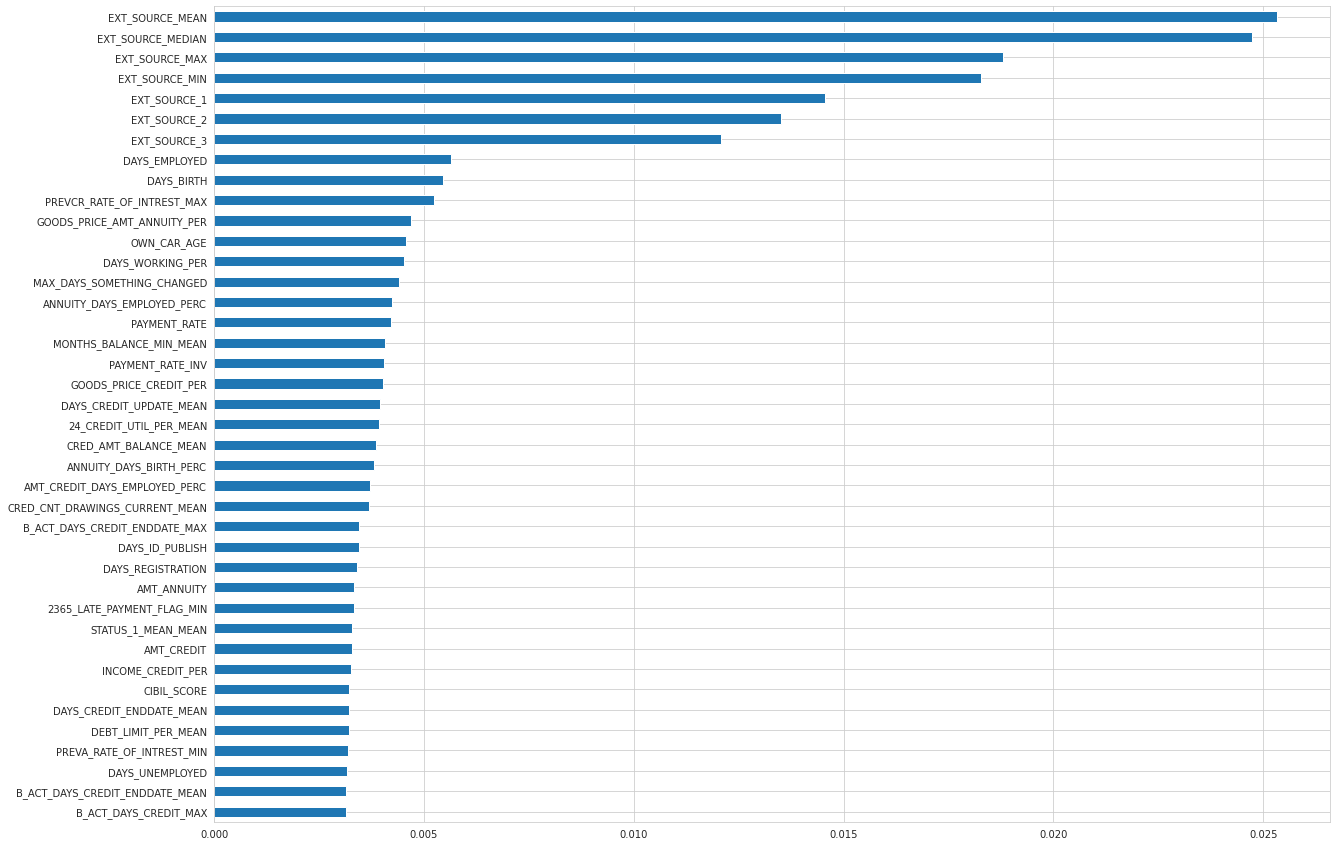

In [36]:
plt.figure(figsize=(20,15))
feat_importances = pd.Series(random_forest.feature_importances_, index=train_column)
feat_importances.nlargest(40).sort_values().plot(kind='barh')

## Summary

### application_train.csv


* The most important feature are EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3 and their min, median, mean, max they show a strong negative coorelation with target
* The DAYS_BIRTH and DAYS_EMPLOYED show a strong positive coorelation with the target.
* The code_gender had an outlier value called NA which was in train and not in test and it was removed
* When we try to plot pair plot between,
	* DAYS_EMPLOYED - How many days before the application the person started current employment
	* DAYS_BIRTH - Client's age in days at the time of application
	* AMT_INCOME_TOTAL - Income of the client
	* AMT_CREDIT - Credit amount of the loan
	* AMT_ANNUITY - Loan annuity
      
      we got some important features like,
    * pecentage of his life spent working, df['DAYS_WORKING_PER']=df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    * percentage income of person and the credit amount, df['INCOME_CREDIT_PER'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    
    * Amount paid  loan application every month decided by the number of day employed, df['ANNUITY_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED']/ df['AMT_ANNUITY']
    
	* Amount credit requested depends on days employed, df['AMT_CREDIT_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED']/ df['AMT_CREDIT']
    

### bureau.csv & bureau_balance.csv

* bureau.csv : All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
* bureau_balance.csv : Monthly balances of previous credits in Credit Bureau.
* The important feature was DAYS_CREDIT which is the number of days from the clients first loan till current application this shows clients experience with loans.
* We got the number of secured loans (eg.car,house) and unsecured loans (eg. credit card,personal loan) in the past which is helpful in calculating CIBIL score.

### previous_application.csv

* All previous applications for Home Credit loans of clients who have loans in our sample.There is one row for each previous application related to loans in our data sample.
* PREV_DAYS_FIRST_DRAWING_MEAN (Mean value of clients all other previous applications relative to application date of current application when was the first disbursement(payment on behalf of client) of the previous application) is an important feature.The Mean of Days of first darwing for previous application for target=0 is less than -2000 and for target=1 is greater than -500 days.

### POS_CASH_balance.csv

* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* Paid Installment feature is number of installments paid by the client
* POS_MONTHS_BALANCE_MIN feature is showing a strong negative coorelation, which is the months of data available less than -60 then target==0 (can repay the loan) and greater than -40 then target==1 (cannot repay the loan)

### credit_card_balance.csv

* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* CRED_CNT_DRAWINGS_ATM_CURRENT_MEAN is the mean drawings from ATM ,<5 then is more likely to be a client who cannot repay the loan. If the number of drawings is >28 then is more likely to be a client who can repay the loan.

### installments_payments.csv

* The table has repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

* The table is used to get information like how many times client has delayed payment and wheather client had paid less amount then actual amount to be paid.

### Handling missing values

* Greater than 75% Missing Values Columns Deleted
* Less than 30% Missing Values median imputation
* Greater than 30 and Less than 75% Missing Values imputation using Ridge Regression

### CIBIL Score

* The newly created feature CIBIL score is in the top 40 features contribuiting in the prediction out of 731 features
